In [1]:
# This project seeks to determine whether better prediction accuracy can be acheived by training a neural net on a non-accuracy parameter and then
# modifying the decision threshold post training to optimize for accuracy
# I will answer this question using the fashion MNIST dataset

# My methodology for answering this question is as follows:
# 1. I will import the fashion MNIST dataset and convert it into a few binary class dataset - I will use just t-shirts/tops and trousers - one of these
# datasets will have a 90/10 class balance, another will have an 80/20 class balance, the third will have a 70/30 class balance, and the last will have 
# a 60/40 class balance
# 2. I will design a CNN architecture to learn to classify the each of the dataset
# 3. For each dataset, I will train my CNN using accuracy, AUC-ROC, balanced accuracy, and F1 - then I will adjust the decision thresholds of the 
# models trained using AUC-ROC, balanced accuracy, and F1 to acheive best accuracy on the validation set
# 4. I will compare each models accuracy on the test set to determine which model performs the best and if class distribution affects the outcome

In [2]:
import keras
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical
import numpy as np

# data load
(X_train_full, y_train_full), (X_test_full, y_test_full) = fashion_mnist.load_data()

train_mask = (y_train_full == 0) | (y_train_full == 1)
test_mask = (y_test_full == 0) | (y_test_full == 1)

X_train_tops_trousers = X_train_full[train_mask]
X_test_tops_trousers = X_test_full[test_mask]

y_train_tops_trousers = y_train_full[train_mask]
y_test_tops_trousers = y_test_full[test_mask]

2025-12-12 19:33:26.585312: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# a validation set will be needed to tune the decision threshold
from sklearn.model_selection import train_test_split

X_train_tops_trousers, X_val_tops_trousers, y_train_tops_trousers, y_val_tops_trousers = train_test_split(
    X_train_tops_trousers, y_train_tops_trousers,
    test_size=0.2,
    random_state=6,
    stratify=y_train_tops_trousers
)

In [4]:
# normalize
X_train_normalized = X_train_tops_trousers / 255.0
X_test_normalized = X_test_tops_trousers / 255.0
X_val_normalized = X_val_tops_trousers / 255.0

label for each of the above image: [0 1 1 1 1]


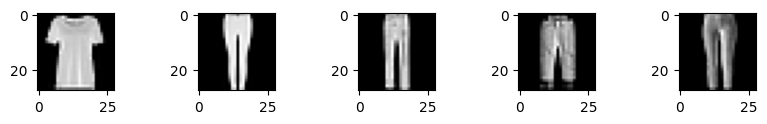

In [5]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 1))
for i in range(5):
    # Set the (i+1)st subplot in a plot with 5 images in 1 row.
    plt.subplot(1, 5, i+1)
    plt.imshow(X_train_tops_trousers[i], cmap="gray")
print('label for each of the above image: %s' % (y_train_tops_trousers[0:5]))

In [6]:
X_train_normalized.size

7526400

In [7]:
y_train_tops_trousers

array([0, 1, 1, ..., 0, 0, 1], dtype=uint8)

In [8]:
# this function resamples the dataset to create the desired class distributions
# the distribution variable is supposed to be a dict object which associates class labels with desired percentages ex: {0: 90, 1:10} tells the function
# to take 90% of class 0 and 10% of class 1
def resample(X, y, distribution):
    seed = 6
    sampler = np.random.default_rng(seed)
    
    chosen_indices = []
    for class_label, percentage in distribution.items():
        class_mask = (y == class_label)
        class_indices = np.where(class_mask)[0]
        size = int(percentage/100 * len(class_indices))
        indices = sampler.choice(class_indices, size, replace=False)
        chosen_indices.append(indices)

    chosen_indices = np.concatenate(chosen_indices)
    sampler.shuffle(chosen_indices)
    return X[chosen_indices], y[chosen_indices]

In [9]:
X_train_90_10, y_train_90_10 = resample(X_train_normalized, y_train_tops_trousers, {0: 90, 1: 10})
X_test_90_10, y_test_90_10 = resample(X_test_normalized, y_test_tops_trousers, {0: 90, 1: 10})
X_val_90_10, y_val_90_10 = resample(X_val_normalized, y_val_tops_trousers, {0: 90, 1: 10})

X_train_80_20, y_train_80_20 = resample(X_train_normalized, y_train_tops_trousers, {0: 80, 1: 20})
X_test_80_20, y_test_80_20 = resample(X_test_normalized, y_test_tops_trousers, {0: 80, 1: 20})
X_val_80_20, y_val_80_20 = resample(X_val_normalized, y_val_tops_trousers, {0: 80, 1: 20})

X_train_70_30, y_train_70_30 = resample(X_train_normalized, y_train_tops_trousers, {0: 70, 1: 30})
X_test_70_30, y_test_70_30 = resample(X_test_normalized, y_test_tops_trousers, {0: 70, 1: 30})
X_val_70_30, y_val_70_30 = resample(X_val_normalized, y_val_tops_trousers, {0: 70, 1: 30})

X_train_60_40, y_train_60_40 = resample(X_train_normalized, y_train_tops_trousers, {0: 60, 1: 40})
X_test_60_40, y_test_60_40 = resample(X_test_normalized, y_test_tops_trousers, {0: 60, 1: 40})
X_val_60_40, y_val_60_40 = resample(X_val_normalized, y_val_tops_trousers, {0: 60, 1: 40})

In [10]:
test_result = lambda x: np.sum(x == 0) / np.sum(y_train_tops_trousers == 0)
print(test_result(y_train_90_10))
print(test_result(y_train_80_20))
print(test_result(y_train_70_30))
print(test_result(y_train_60_40))

0.9
0.8
0.7
0.6


In [11]:
# Convert to "one-hot" vectors using the to_categorical function
num_classes = 2

y_train_90_10_cat = to_categorical(y_train_90_10, num_classes)
y_test_90_10_cat = to_categorical(y_test_90_10, num_classes)
y_val_90_10_cat = to_categorical(y_val_90_10, num_classes)

y_train_80_20_cat = to_categorical(y_train_80_20, num_classes)
y_test_80_20_cat = to_categorical(y_test_80_20, num_classes)
y_val_80_20_cat = to_categorical(y_val_80_20, num_classes)

y_train_70_30_cat = to_categorical(y_train_70_30, num_classes)
y_test_70_30_cat = to_categorical(y_test_70_30, num_classes)
y_val_70_30_cat = to_categorical(y_val_70_30, num_classes)

y_train_60_40_cat = to_categorical(y_train_60_40, num_classes)
y_test_60_40_cat = to_categorical(y_test_60_40, num_classes)
y_val_60_40_cat = to_categorical(y_val_60_40, num_classes)

In [12]:
# now I will design my CNN architecture
# I will note here that the focus of this project is on comparing the results of one model trained using different metrics. Due to the fact that I'm
# not necessarily trying to build a model that acheives a super incredible performance, I will prioritize designing an architecture that will train
# quickly so that I can train on all of my datasets

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam

# Intializing a sequential model
model_cnn = Sequential()

# Adding first conv layer with 64 filters and kernel size 3x3 , padding 'same' provides the output size same as the input size
# 64 filters produce 64 feature maps
# Input_shape denotes input image dimension of MNIST images
model_cnn.add(Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(28, 28, 1)))
# Adding max pooling to reduce the size of output of first conv layer
model_cnn.add(MaxPooling2D((2, 2), padding = 'same'))

model_cnn.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model_cnn.add(MaxPooling2D((2, 2), padding = 'same'))

model_cnn.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model_cnn.add(MaxPooling2D((2, 2), padding = 'same'))

# flattening the output of the conv layer after max pooling to make it ready for creating dense connections
model_cnn.add(Flatten())

# Adding a fully connected dense layer with 100 neurons
model_cnn.add(Dense(100, activation='relu'))

# Adding the output layer with 1 neuron and activation functions as sigmoid since this is a binary-class classification problem
model_cnn.add(Dense(1, activation='sigmoid'))

# Need to save the initial weights to train each cnn from scratch
initial_weights = model_cnn.get_weights()

/usr/local/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-12-12 19:33:30.957889: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [13]:
# pairwise-hinge loss will be used for the AUC-ROC surrogate loss function

import tensorflow as tf

def pairwise_hinge_loss(margin=1.0):
    """
    Pairwise hinge ranking loss for binary classification (AUC surrogate).
    Works with sigmoid outputs in (0,1).

    y_true: shape (batch,) or (batch,1), values {0,1}
    y_pred: shape (batch,) or (batch,1), values in (0,1) from sigmoid
    """
    def loss_fn(y_true, y_pred):
        y_true = tf.cast(tf.reshape(y_true, [-1]), tf.float32)   # shape (B,)
        y_pred = tf.cast(tf.reshape(y_pred, [-1]), tf.float32)   # shape (B,)

        # masks for positives and negatives
        pos_mask = tf.equal(y_true, 1.0)
        neg_mask = tf.equal(y_true, 0.0)

        pos_scores = tf.boolean_mask(y_pred, pos_mask)   # (#pos,)
        neg_scores = tf.boolean_mask(y_pred, neg_mask)   # (#neg,)

        # If a batch has no pos or no neg, return zero loss
        if_pos_or_neg_missing = tf.logical_or(
            tf.equal(tf.size(pos_scores), 0),
            tf.equal(tf.size(neg_scores), 0)
        )
        def zero_loss():
            return tf.constant(0.0, dtype=tf.float32)

        def compute_loss():
            # Compute pairwise score differences (broadcasting)
            # shape: (#pos, #neg)
            diffs = tf.expand_dims(pos_scores, axis=1) - tf.expand_dims(neg_scores, axis=0)

            # hinge: max(0, margin - (pos - neg))
            violations = margin - diffs
            losses = tf.nn.relu(violations)

            # average over all pairs
            return tf.reduce_mean(losses)

        return tf.cond(if_pos_or_neg_missing, zero_loss, compute_loss)

    return loss_fn

In [14]:
# "soft" balanced accuracy loss function - this will just be balanced accuracy but instead of forcing the model to predict labels to be 0s or 1s, we
# will use the continuous prediction: y_hat belongs to (0, 1)
# we use epsilon (1e-7) here to prevent predicted values and denominators from hitting 0 or 1

def balanced_accuracy_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.clip_by_value(y_pred, 1e-7, 1-1e-7)

    tp = tf.reduce_sum(y_true * y_pred)
    tn = tf.reduce_sum((1 - y_true) * (1 - y_pred))
    fp = tf.reduce_sum((1 - y_true) * y_pred)
    fn = tf.reduce_sum(y_true * (1 - y_pred))

    tpr = tp / (tp + fn + 1e-7)
    tnr = tn / (tn + fp + 1e-7)

    ba = 0.5 * (tpr + tnr)

    return 1 - ba

In [15]:
# "soft" F1 loss - same idea as soft balanced accuracy loss here - we will use softmax predictions for differentiability

def f1_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    tp = tf.reduce_sum(y_true * y_pred)
    fp = tf.reduce_sum((1 - y_true) * y_pred)
    fn = tf.reduce_sum(y_true * (1 - y_pred))

    f1 = (2 * tp) / (2 * tp + fp + fn + 1e-7)
    return 1 - f1

In [16]:
# now I want to write a decision threshold tuning function that I can apply post-training to my pairwise hinge, balanced accuracy, and F1 loss models

from sklearn.metrics import accuracy_score

def tune_threshold(X_val, y_val, model):
    output_probs = model.predict(X_val)
    thresholds = np.linspace(0, 1, 500)
    best_accuracy = -1
    best_threshold = 0.5
    for threshold in thresholds:
        preds = (output_probs >= threshold).astype(int)
        accuracy = accuracy_score(y_val, preds)
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_threshold = threshold

    return best_accuracy, best_threshold

In [17]:
# I also want to build a pipeline that I can use to automatically tune my threshold and calculate test accuracy

from sklearn.metrics import accuracy_score

def train_tune_test_pipeline(model, X_train, y_train, X_val, y_val, X_test, y_test, loss_name, loss_fn, split):
    model.set_weights(initial_weights)
    model.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])
    model.summary()
    model.fit(X_train, y_train[:, 1], validation_data=(X_val, y_val[:, 1]), epochs=10, batch_size=128, verbose=2)
    best_accuracy, best_threshold = tune_threshold(X_val, y_val[:, 1], model)
    test_probs = model.predict(X_test)
    preds = (test_probs > best_threshold).astype(int)
    accuracy = accuracy_score(y_test[:, 1], preds)
    no_tuning_preds = (test_probs > 0.5).astype(int)
    no_tuning_accuracy = accuracy_score(y_test[:, 1], no_tuning_preds)
    print("Using:", loss_name, "on:", split)
    print("test accuracy:", accuracy, "using best threshold:", best_threshold)
    print("with 0.5 threshold:", no_tuning_accuracy)
    return accuracy, best_threshold, no_tuning_accuracy

In [18]:
## Now we will start to fit the model to our different datasets
# we will use binary_crossentropy as a our standard loss function representing optimizing for accuracy, and our surrogate loss functions representing
# F1, balanced accuracy, and AUC-ROC as described above

In [19]:
# here I will write a function that runs the pipeline for every combination of data imbalance and loss function

data_splits = {
    "90_10": {
        "X_train": X_train_90_10,
        "y_train": y_train_90_10_cat,
        "X_val":   X_val_90_10,
        "y_val":   y_val_90_10_cat,
        "X_test":  X_test_90_10,
        "y_test":  y_test_90_10_cat,
    },
    "80_20": {
        "X_train": X_train_80_20,
        "y_train": y_train_80_20_cat,
        "X_val":   X_val_80_20,
        "y_val":   y_val_80_20_cat,
        "X_test":  X_test_80_20,
        "y_test":  y_test_80_20_cat,
    },
    "70_30": {
        "X_train": X_train_70_30,
        "y_train": y_train_70_30_cat,
        "X_val":   X_val_70_30,
        "y_val":   y_val_70_30_cat,
        "X_test":  X_test_70_30,
        "y_test":  y_test_70_30_cat,
    },
    "60_40": {
        "X_train": X_train_60_40,
        "y_train": y_train_60_40_cat,
        "X_val":   X_val_60_40,
        "y_val":   y_val_60_40_cat,
        "X_test":  X_test_60_40,
        "y_test":  y_test_60_40_cat,
    },
}

loss_fns = {
    "binary crossentropy": "binary_crossentropy",
    "pairwise hinge loss (AUC-ROC surrogate)": pairwise_hinge_loss(margin=1.0),
    "balanced accuracy loss": balanced_accuracy_loss,
    "F1 loss": f1_loss
}

splits = ["90_10", "80_20", "70_30", "60_40"]
results = []

for split in splits:
    for loss_name, loss_fn in loss_fns.items():
        data = data_splits[split]
        accuracy, best_threshold, no_tuning_accuracy = train_tune_test_pipeline(model_cnn,
                         data["X_train"], data["y_train"],
                         data["X_val"], data["y_val"],
                         data["X_test"], data["y_test"],
                         loss_name, loss_fn, split)
        results.append({
            "split": split,
            "loss": loss_name,
            "best threshold": best_threshold,
            "best accuracy": accuracy,
            "accuracy at threshold = 0.5": no_tuning_accuracy,
        })

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │        51,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,753 (311.54 KB)

 Trainable params: 79,753 (311.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
38/38 - 3s - 84ms/step - accuracy: 0.8900 - loss: 0.2875 - val_accuracy: 0.9808 - val_loss: 0.0751
Epoch 2/10
38/38 - 2s - 41ms/step - accuracy: 0.9873 - loss: 0.0611 - val_accuracy: 0.9942 - val_loss: 0.0283
Epoch 3/10
38/38 - 2s - 41ms/step - accuracy: 0.9937 - loss: 0.0297 - val_accuracy: 0.9967 - val_loss: 0.0176
Epoch 4/10
38/38 - 1s - 39ms/step - accuracy: 0.9950 - loss: 0.0162 - val_accuracy: 0.9967 - val_loss: 0.0120
Epoch 5/10
38/38 - 2s - 41ms/step - accuracy: 0.9971 - loss: 0.0112 - val_accuracy: 0.9967 - val_loss: 0.0123
Epoch 6/10
38/38 - 2s - 41ms/step - accuracy: 0.9962 - loss: 0.0106 - val_accuracy: 0.9958 - val_loss: 0.0132
Epoch 7/10
38/38 - 1s - 38ms/step - accuracy: 0.9977 - loss: 0.0088 - val_accuracy: 0.9975 - val_loss: 0.0116
Epoch 8/10
38/38 - 1s - 38ms/step - accuracy: 0.9973 - loss: 0.0093 - val_accuracy: 0.9967 - val_loss: 0.0095
Epoch 9/10
38/38 - 1s - 39ms/step - accuracy: 0.9975 - loss: 0.0085 - val_accuracy: 0.9967 - val_loss: 0.0098
Epoch 10/1

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │        51,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,753 (311.54 KB)

 Trainable params: 79,753 (311.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
38/38 - 3s - 86ms/step - accuracy: 0.9183 - loss: 0.3526 - val_accuracy: 0.9283 - val_loss: 0.0859
Epoch 2/10
38/38 - 1s - 39ms/step - accuracy: 0.9592 - loss: 0.0866 - val_accuracy: 0.9925 - val_loss: 0.0788
Epoch 3/10
38/38 - 2s - 41ms/step - accuracy: 0.9846 - loss: 0.0645 - val_accuracy: 0.9950 - val_loss: 0.0202
Epoch 4/10
38/38 - 3s - 67ms/step - accuracy: 0.9921 - loss: 0.0345 - val_accuracy: 0.9975 - val_loss: 0.0170
Epoch 5/10
38/38 - 2s - 42ms/step - accuracy: 0.9912 - loss: 0.0286 - val_accuracy: 0.9925 - val_loss: 0.0175
Epoch 6/10
38/38 - 2s - 40ms/step - accuracy: 0.9962 - loss: 0.0169 - val_accuracy: 0.9958 - val_loss: 0.0175
Epoch 7/10
38/38 - 2s - 40ms/step - accuracy: 0.9962 - loss: 0.0193 - val_accuracy: 0.9958 - val_loss: 0.0093
Epoch 8/10
38/38 - 1s - 39ms/step - accuracy: 0.9973 - loss: 0.0158 - val_accuracy: 0.9983 - val_loss: 0.0125
Epoch 9/10
38/38 - 1s - 39ms/step - accuracy: 0.9979 - loss: 0.0133 - val_accuracy: 0.9983 - val_loss: 0.0133
Epoch 10/1

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │        51,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,753 (311.54 KB)

 Trainable params: 79,753 (311.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
38/38 - 3s - 80ms/step - accuracy: 0.9204 - loss: 0.1854 - val_accuracy: 0.9900 - val_loss: 0.0630
Epoch 2/10
38/38 - 2s - 41ms/step - accuracy: 0.9802 - loss: 0.0419 - val_accuracy: 0.9917 - val_loss: 0.0376
Epoch 3/10
38/38 - 2s - 42ms/step - accuracy: 0.9704 - loss: 0.0382 - val_accuracy: 0.9950 - val_loss: 0.0389
Epoch 4/10
38/38 - 2s - 41ms/step - accuracy: 0.9829 - loss: 0.0243 - val_accuracy: 0.9900 - val_loss: 0.0294
Epoch 5/10
38/38 - 3s - 67ms/step - accuracy: 0.9881 - loss: 0.0192 - val_accuracy: 0.9967 - val_loss: 0.0277
Epoch 6/10
38/38 - 1s - 39ms/step - accuracy: 0.9946 - loss: 0.0152 - val_accuracy: 0.9883 - val_loss: 0.0303
Epoch 7/10
38/38 - 2s - 40ms/step - accuracy: 0.9921 - loss: 0.0199 - val_accuracy: 0.9808 - val_loss: 0.0342
Epoch 8/10
38/38 - 2s - 41ms/step - accuracy: 0.9915 - loss: 0.0131 - val_accuracy: 0.9950 - val_loss: 0.0308
Epoch 9/10
38/38 - 1s - 38ms/step - accuracy: 0.9935 - loss: 0.0108 - val_accuracy: 0.9975 - val_loss: 0.0293
Epoch 10/1

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │        51,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,753 (311.54 KB)

 Trainable params: 79,753 (311.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
38/38 - 3s - 79ms/step - accuracy: 0.8202 - loss: 0.3796 - val_accuracy: 0.9717 - val_loss: 0.1644
Epoch 2/10
38/38 - 2s - 61ms/step - accuracy: 0.9812 - loss: 0.1012 - val_accuracy: 0.9917 - val_loss: 0.0818
Epoch 3/10
38/38 - 1s - 38ms/step - accuracy: 0.9906 - loss: 0.0488 - val_accuracy: 0.9942 - val_loss: 0.0721
Epoch 4/10
38/38 - 2s - 40ms/step - accuracy: 0.9931 - loss: 0.0369 - val_accuracy: 0.9967 - val_loss: 0.0573
Epoch 5/10
38/38 - 2s - 40ms/step - accuracy: 0.9952 - loss: 0.0298 - val_accuracy: 0.9975 - val_loss: 0.0537
Epoch 6/10
38/38 - 2s - 40ms/step - accuracy: 0.9960 - loss: 0.0255 - val_accuracy: 0.9983 - val_loss: 0.0517
Epoch 7/10
38/38 - 1s - 39ms/step - accuracy: 0.9960 - loss: 0.0239 - val_accuracy: 0.9967 - val_loss: 0.0597
Epoch 8/10
38/38 - 1s - 39ms/step - accuracy: 0.9954 - loss: 0.0248 - val_accuracy: 0.9967 - val_loss: 0.0549
Epoch 9/10
38/38 - 2s - 41ms/step - accuracy: 0.9954 - loss: 0.0251 - val_accuracy: 0.9975 - val_loss: 0.0517
Epoch 10/1

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │        51,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,753 (311.54 KB)

 Trainable params: 79,753 (311.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
38/38 - 3s - 80ms/step - accuracy: 0.8567 - loss: 0.3221 - val_accuracy: 0.9700 - val_loss: 0.1220
Epoch 2/10
38/38 - 2s - 40ms/step - accuracy: 0.9827 - loss: 0.0651 - val_accuracy: 0.9925 - val_loss: 0.0300
Epoch 3/10
38/38 - 2s - 41ms/step - accuracy: 0.9915 - loss: 0.0276 - val_accuracy: 0.9933 - val_loss: 0.0231
Epoch 4/10
38/38 - 2s - 40ms/step - accuracy: 0.9950 - loss: 0.0190 - val_accuracy: 0.9942 - val_loss: 0.0220
Epoch 5/10
38/38 - 1s - 39ms/step - accuracy: 0.9948 - loss: 0.0191 - val_accuracy: 0.9942 - val_loss: 0.0213
Epoch 6/10
38/38 - 2s - 41ms/step - accuracy: 0.9956 - loss: 0.0144 - val_accuracy: 0.9950 - val_loss: 0.0223
Epoch 7/10
38/38 - 2s - 41ms/step - accuracy: 0.9962 - loss: 0.0141 - val_accuracy: 0.9958 - val_loss: 0.0222
Epoch 8/10
38/38 - 2s - 40ms/step - accuracy: 0.9946 - loss: 0.0152 - val_accuracy: 0.9942 - val_loss: 0.0250
Epoch 9/10
38/38 - 2s - 42ms/step - accuracy: 0.9956 - loss: 0.0138 - val_accuracy: 0.9958 - val_loss: 0.0225
Epoch 10/1

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │        51,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,753 (311.54 KB)

 Trainable params: 79,753 (311.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
38/38 - 3s - 88ms/step - accuracy: 0.9129 - loss: 0.3712 - val_accuracy: 0.9633 - val_loss: 0.1187
Epoch 2/10
38/38 - 1s - 39ms/step - accuracy: 0.9752 - loss: 0.0814 - val_accuracy: 0.9833 - val_loss: 0.0908
Epoch 3/10
38/38 - 1s - 38ms/step - accuracy: 0.9829 - loss: 0.0534 - val_accuracy: 0.9917 - val_loss: 0.0331
Epoch 4/10
38/38 - 2s - 40ms/step - accuracy: 0.9917 - loss: 0.0313 - val_accuracy: 0.9925 - val_loss: 0.0294
Epoch 5/10
38/38 - 1s - 39ms/step - accuracy: 0.9906 - loss: 0.0281 - val_accuracy: 0.9917 - val_loss: 0.0237
Epoch 6/10
38/38 - 2s - 41ms/step - accuracy: 0.9910 - loss: 0.0225 - val_accuracy: 0.9933 - val_loss: 0.0215
Epoch 7/10
38/38 - 1s - 38ms/step - accuracy: 0.9940 - loss: 0.0173 - val_accuracy: 0.9917 - val_loss: 0.0196
Epoch 8/10
38/38 - 1s - 39ms/step - accuracy: 0.9912 - loss: 0.0225 - val_accuracy: 0.9875 - val_loss: 0.0236
Epoch 9/10
38/38 - 1s - 39ms/step - accuracy: 0.9915 - loss: 0.0195 - val_accuracy: 0.9925 - val_loss: 0.0193
Epoch 10/1

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │        51,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,753 (311.54 KB)

 Trainable params: 79,753 (311.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
38/38 - 3s - 89ms/step - accuracy: 0.9062 - loss: 0.1802 - val_accuracy: 0.9025 - val_loss: 0.0855
Epoch 2/10
38/38 - 1s - 39ms/step - accuracy: 0.9677 - loss: 0.0430 - val_accuracy: 0.9700 - val_loss: 0.0406
Epoch 3/10
38/38 - 3s - 66ms/step - accuracy: 0.9821 - loss: 0.0318 - val_accuracy: 0.9700 - val_loss: 0.0288
Epoch 4/10
38/38 - 2s - 40ms/step - accuracy: 0.9873 - loss: 0.0197 - val_accuracy: 0.9925 - val_loss: 0.0154
Epoch 5/10
38/38 - 1s - 39ms/step - accuracy: 0.9923 - loss: 0.0125 - val_accuracy: 0.9967 - val_loss: 0.0096
Epoch 6/10
38/38 - 1s - 38ms/step - accuracy: 0.9923 - loss: 0.0118 - val_accuracy: 0.9900 - val_loss: 0.0113
Epoch 7/10
38/38 - 1s - 39ms/step - accuracy: 0.9921 - loss: 0.0120 - val_accuracy: 0.9950 - val_loss: 0.0113
Epoch 8/10
38/38 - 1s - 37ms/step - accuracy: 0.9937 - loss: 0.0091 - val_accuracy: 0.9933 - val_loss: 0.0083
Epoch 9/10
38/38 - 1s - 39ms/step - accuracy: 0.9937 - loss: 0.0079 - val_accuracy: 0.9917 - val_loss: 0.0088
Epoch 10/1

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │        51,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,753 (311.54 KB)

 Trainable params: 79,753 (311.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
38/38 - 3s - 78ms/step - accuracy: 0.7567 - loss: 0.3056 - val_accuracy: 0.9683 - val_loss: 0.1035
Epoch 2/10
38/38 - 2s - 40ms/step - accuracy: 0.9804 - loss: 0.0533 - val_accuracy: 0.9842 - val_loss: 0.0512
Epoch 3/10
38/38 - 2s - 40ms/step - accuracy: 0.9862 - loss: 0.0370 - val_accuracy: 0.9867 - val_loss: 0.0433
Epoch 4/10
38/38 - 1s - 39ms/step - accuracy: 0.9898 - loss: 0.0283 - val_accuracy: 0.9908 - val_loss: 0.0249
Epoch 5/10
38/38 - 2s - 40ms/step - accuracy: 0.9896 - loss: 0.0285 - val_accuracy: 0.9792 - val_loss: 0.0561
Epoch 6/10
38/38 - 1s - 38ms/step - accuracy: 0.9919 - loss: 0.0204 - val_accuracy: 0.9925 - val_loss: 0.0208
Epoch 7/10
38/38 - 2s - 40ms/step - accuracy: 0.9954 - loss: 0.0145 - val_accuracy: 0.9933 - val_loss: 0.0204
Epoch 8/10
38/38 - 2s - 40ms/step - accuracy: 0.9956 - loss: 0.0126 - val_accuracy: 0.9950 - val_loss: 0.0178
Epoch 9/10
38/38 - 1s - 39ms/step - accuracy: 0.9952 - loss: 0.0145 - val_accuracy: 0.9950 - val_loss: 0.0174
Epoch 10/1

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │        51,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,753 (311.54 KB)

 Trainable params: 79,753 (311.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
38/38 - 3s - 78ms/step - accuracy: 0.8573 - loss: 0.3178 - val_accuracy: 0.9650 - val_loss: 0.1074
Epoch 2/10
38/38 - 1s - 39ms/step - accuracy: 0.9798 - loss: 0.0646 - val_accuracy: 0.9933 - val_loss: 0.0324
Epoch 3/10
38/38 - 1s - 39ms/step - accuracy: 0.9921 - loss: 0.0274 - val_accuracy: 0.9925 - val_loss: 0.0304
Epoch 4/10
38/38 - 2s - 40ms/step - accuracy: 0.9931 - loss: 0.0239 - val_accuracy: 0.9942 - val_loss: 0.0222
Epoch 5/10
38/38 - 1s - 39ms/step - accuracy: 0.9940 - loss: 0.0264 - val_accuracy: 0.9925 - val_loss: 0.0268
Epoch 6/10
38/38 - 1s - 39ms/step - accuracy: 0.9912 - loss: 0.0267 - val_accuracy: 0.9917 - val_loss: 0.0243
Epoch 7/10
38/38 - 1s - 38ms/step - accuracy: 0.9942 - loss: 0.0197 - val_accuracy: 0.9925 - val_loss: 0.0209
Epoch 8/10
38/38 - 1s - 38ms/step - accuracy: 0.9944 - loss: 0.0171 - val_accuracy: 0.9942 - val_loss: 0.0201
Epoch 9/10
38/38 - 1s - 39ms/step - accuracy: 0.9962 - loss: 0.0128 - val_accuracy: 0.9950 - val_loss: 0.0185
Epoch 10/1

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │        51,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,753 (311.54 KB)

 Trainable params: 79,753 (311.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
38/38 - 3s - 88ms/step - accuracy: 0.9194 - loss: 0.3688 - val_accuracy: 0.9767 - val_loss: 0.0693
Epoch 2/10
38/38 - 2s - 42ms/step - accuracy: 0.9729 - loss: 0.0712 - val_accuracy: 0.9892 - val_loss: 0.0407
Epoch 3/10
38/38 - 2s - 41ms/step - accuracy: 0.9842 - loss: 0.0464 - val_accuracy: 0.9917 - val_loss: 0.0303
Epoch 4/10
38/38 - 2s - 40ms/step - accuracy: 0.9833 - loss: 0.0430 - val_accuracy: 0.9892 - val_loss: 0.0258
Epoch 5/10
38/38 - 2s - 40ms/step - accuracy: 0.9900 - loss: 0.0274 - val_accuracy: 0.9908 - val_loss: 0.0305
Epoch 6/10
38/38 - 1s - 39ms/step - accuracy: 0.9925 - loss: 0.0226 - val_accuracy: 0.9858 - val_loss: 0.0270
Epoch 7/10
38/38 - 1s - 39ms/step - accuracy: 0.9921 - loss: 0.0215 - val_accuracy: 0.9958 - val_loss: 0.0169
Epoch 8/10
38/38 - 2s - 40ms/step - accuracy: 0.9927 - loss: 0.0197 - val_accuracy: 0.9950 - val_loss: 0.0159
Epoch 9/10
38/38 - 2s - 40ms/step - accuracy: 0.9935 - loss: 0.0167 - val_accuracy: 0.9925 - val_loss: 0.0242
Epoch 10/1

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │        51,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,753 (311.54 KB)

 Trainable params: 79,753 (311.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
38/38 - 3s - 79ms/step - accuracy: 0.9223 - loss: 0.1804 - val_accuracy: 0.9767 - val_loss: 0.0305
Epoch 2/10
38/38 - 1s - 39ms/step - accuracy: 0.9756 - loss: 0.0328 - val_accuracy: 0.9892 - val_loss: 0.0195
Epoch 3/10
38/38 - 2s - 40ms/step - accuracy: 0.9835 - loss: 0.0215 - val_accuracy: 0.9892 - val_loss: 0.0177
Epoch 4/10
38/38 - 2s - 41ms/step - accuracy: 0.9900 - loss: 0.0144 - val_accuracy: 0.9942 - val_loss: 0.0094
Epoch 5/10
38/38 - 2s - 40ms/step - accuracy: 0.9912 - loss: 0.0122 - val_accuracy: 0.9933 - val_loss: 0.0108
Epoch 6/10
38/38 - 1s - 39ms/step - accuracy: 0.9912 - loss: 0.0109 - val_accuracy: 0.9958 - val_loss: 0.0086
Epoch 7/10
38/38 - 1s - 39ms/step - accuracy: 0.9931 - loss: 0.0097 - val_accuracy: 0.9925 - val_loss: 0.0092
Epoch 8/10
38/38 - 2s - 40ms/step - accuracy: 0.9927 - loss: 0.0091 - val_accuracy: 0.9925 - val_loss: 0.0087
Epoch 9/10
38/38 - 1s - 39ms/step - accuracy: 0.9935 - loss: 0.0083 - val_accuracy: 0.9933 - val_loss: 0.0079
Epoch 10/1

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │        51,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,753 (311.54 KB)

 Trainable params: 79,753 (311.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
38/38 - 3s - 80ms/step - accuracy: 0.7385 - loss: 0.2813 - val_accuracy: 0.9642 - val_loss: 0.0647
Epoch 2/10
38/38 - 2s - 40ms/step - accuracy: 0.9712 - loss: 0.0532 - val_accuracy: 0.9842 - val_loss: 0.0317
Epoch 3/10
38/38 - 2s - 40ms/step - accuracy: 0.9829 - loss: 0.0300 - val_accuracy: 0.9867 - val_loss: 0.0246
Epoch 4/10
38/38 - 2s - 40ms/step - accuracy: 0.9840 - loss: 0.0280 - val_accuracy: 0.9908 - val_loss: 0.0154
Epoch 5/10
38/38 - 2s - 41ms/step - accuracy: 0.9885 - loss: 0.0208 - val_accuracy: 0.9917 - val_loss: 0.0152
Epoch 6/10
38/38 - 2s - 40ms/step - accuracy: 0.9910 - loss: 0.0156 - val_accuracy: 0.9908 - val_loss: 0.0173
Epoch 7/10
38/38 - 2s - 40ms/step - accuracy: 0.9935 - loss: 0.0131 - val_accuracy: 0.9917 - val_loss: 0.0157
Epoch 8/10
38/38 - 2s - 41ms/step - accuracy: 0.9910 - loss: 0.0155 - val_accuracy: 0.9958 - val_loss: 0.0098
Epoch 9/10
38/38 - 2s - 41ms/step - accuracy: 0.9923 - loss: 0.0136 - val_accuracy: 0.9900 - val_loss: 0.0178
Epoch 10/1

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │        51,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,753 (311.54 KB)

 Trainable params: 79,753 (311.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
38/38 - 3s - 91ms/step - accuracy: 0.8452 - loss: 0.3130 - val_accuracy: 0.9867 - val_loss: 0.0583
Epoch 2/10
38/38 - 1s - 39ms/step - accuracy: 0.9879 - loss: 0.0418 - val_accuracy: 0.9942 - val_loss: 0.0224
Epoch 3/10
38/38 - 1s - 39ms/step - accuracy: 0.9937 - loss: 0.0208 - val_accuracy: 0.9950 - val_loss: 0.0188
Epoch 4/10
38/38 - 2s - 40ms/step - accuracy: 0.9942 - loss: 0.0191 - val_accuracy: 0.9950 - val_loss: 0.0174
Epoch 5/10
38/38 - 1s - 39ms/step - accuracy: 0.9956 - loss: 0.0172 - val_accuracy: 0.9950 - val_loss: 0.0179
Epoch 6/10
38/38 - 1s - 39ms/step - accuracy: 0.9950 - loss: 0.0153 - val_accuracy: 0.9942 - val_loss: 0.0205
Epoch 7/10
38/38 - 2s - 40ms/step - accuracy: 0.9965 - loss: 0.0134 - val_accuracy: 0.9942 - val_loss: 0.0221
Epoch 8/10
38/38 - 1s - 39ms/step - accuracy: 0.9960 - loss: 0.0130 - val_accuracy: 0.9942 - val_loss: 0.0255
Epoch 9/10
38/38 - 2s - 40ms/step - accuracy: 0.9960 - loss: 0.0104 - val_accuracy: 0.9950 - val_loss: 0.0153
Epoch 10/1

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │        51,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,753 (311.54 KB)

 Trainable params: 79,753 (311.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
38/38 - 3s - 85ms/step - accuracy: 0.9202 - loss: 0.3589 - val_accuracy: 0.9758 - val_loss: 0.0589
Epoch 2/10
38/38 - 1s - 37ms/step - accuracy: 0.9731 - loss: 0.0652 - val_accuracy: 0.9867 - val_loss: 0.0358
Epoch 3/10
38/38 - 2s - 40ms/step - accuracy: 0.9842 - loss: 0.0369 - val_accuracy: 0.9908 - val_loss: 0.0242
Epoch 4/10
38/38 - 1s - 39ms/step - accuracy: 0.9898 - loss: 0.0241 - val_accuracy: 0.9892 - val_loss: 0.0232
Epoch 5/10
38/38 - 1s - 38ms/step - accuracy: 0.9912 - loss: 0.0193 - val_accuracy: 0.9950 - val_loss: 0.0117
Epoch 6/10
38/38 - 1s - 38ms/step - accuracy: 0.9948 - loss: 0.0135 - val_accuracy: 0.9925 - val_loss: 0.0162
Epoch 7/10
38/38 - 2s - 40ms/step - accuracy: 0.9950 - loss: 0.0126 - val_accuracy: 0.9958 - val_loss: 0.0098
Epoch 8/10
38/38 - 1s - 38ms/step - accuracy: 0.9950 - loss: 0.0114 - val_accuracy: 0.9917 - val_loss: 0.0205
Epoch 9/10
38/38 - 2s - 41ms/step - accuracy: 0.9937 - loss: 0.0142 - val_accuracy: 0.9958 - val_loss: 0.0108
Epoch 10/1

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │        51,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,753 (311.54 KB)

 Trainable params: 79,753 (311.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
38/38 - 3s - 81ms/step - accuracy: 0.9279 - loss: 0.1828 - val_accuracy: 0.9775 - val_loss: 0.0287
Epoch 2/10
38/38 - 1s - 39ms/step - accuracy: 0.9719 - loss: 0.0330 - val_accuracy: 0.9875 - val_loss: 0.0146
Epoch 3/10
38/38 - 1s - 38ms/step - accuracy: 0.9812 - loss: 0.0212 - val_accuracy: 0.9942 - val_loss: 0.0077
Epoch 4/10
38/38 - 1s - 38ms/step - accuracy: 0.9898 - loss: 0.0130 - val_accuracy: 0.9917 - val_loss: 0.0080
Epoch 5/10
38/38 - 1s - 36ms/step - accuracy: 0.9921 - loss: 0.0088 - val_accuracy: 0.9950 - val_loss: 0.0061
Epoch 6/10
38/38 - 1s - 35ms/step - accuracy: 0.9944 - loss: 0.0068 - val_accuracy: 0.9950 - val_loss: 0.0060
Epoch 7/10
38/38 - 1s - 39ms/step - accuracy: 0.9954 - loss: 0.0057 - val_accuracy: 0.9958 - val_loss: 0.0057
Epoch 8/10
38/38 - 1s - 39ms/step - accuracy: 0.9948 - loss: 0.0052 - val_accuracy: 0.9900 - val_loss: 0.0094
Epoch 9/10
38/38 - 1s - 39ms/step - accuracy: 0.9946 - loss: 0.0063 - val_accuracy: 0.9917 - val_loss: 0.0085
Epoch 10/1

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │        51,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,753 (311.54 KB)

 Trainable params: 79,753 (311.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
38/38 - 3s - 79ms/step - accuracy: 0.6946 - loss: 0.2761 - val_accuracy: 0.9592 - val_loss: 0.0563
Epoch 2/10
38/38 - 1s - 39ms/step - accuracy: 0.9560 - loss: 0.0580 - val_accuracy: 0.9808 - val_loss: 0.0262
Epoch 3/10
38/38 - 1s - 39ms/step - accuracy: 0.9802 - loss: 0.0282 - val_accuracy: 0.9867 - val_loss: 0.0186
Epoch 4/10
38/38 - 2s - 42ms/step - accuracy: 0.9854 - loss: 0.0191 - val_accuracy: 0.9883 - val_loss: 0.0176
Epoch 5/10
38/38 - 1s - 39ms/step - accuracy: 0.9898 - loss: 0.0151 - val_accuracy: 0.9917 - val_loss: 0.0119
Epoch 6/10
38/38 - 1s - 39ms/step - accuracy: 0.9923 - loss: 0.0101 - val_accuracy: 0.9950 - val_loss: 0.0075
Epoch 7/10
38/38 - 2s - 40ms/step - accuracy: 0.9952 - loss: 0.0071 - val_accuracy: 0.9908 - val_loss: 0.0123
Epoch 8/10
38/38 - 2s - 40ms/step - accuracy: 0.9946 - loss: 0.0086 - val_accuracy: 0.9933 - val_loss: 0.0088
Epoch 9/10
38/38 - 1s - 39ms/step - accuracy: 0.9952 - loss: 0.0076 - val_accuracy: 0.9942 - val_loss: 0.0077
Epoch 10/1

In [20]:
results

[{'split': '90_10',
  'loss': 'binary crossentropy',
  'best threshold': np.float64(0.03607214428857715),
  'best accuracy': 0.999,
  'accuracy at threshold = 0.5': 0.998},
 {'split': '90_10',
  'loss': 'pairwise hinge loss (AUC-ROC surrogate)',
  'best threshold': np.float64(0.044088176352705406),
  'best accuracy': 0.995,
  'accuracy at threshold = 0.5': 0.998},
 {'split': '90_10',
  'loss': 'balanced accuracy loss',
  'best threshold': np.float64(0.2004008016032064),
  'best accuracy': 0.996,
  'accuracy at threshold = 0.5': 0.997},
 {'split': '90_10',
  'loss': 'F1 loss',
  'best threshold': np.float64(0.2685370741482966),
  'best accuracy': 0.995,
  'accuracy at threshold = 0.5': 0.993},
 {'split': '80_20',
  'loss': 'binary crossentropy',
  'best threshold': np.float64(0.5090180360721442),
  'best accuracy': 0.996,
  'accuracy at threshold = 0.5': 0.996},
 {'split': '80_20',
  'loss': 'pairwise hinge loss (AUC-ROC surrogate)',
  'best threshold': np.float64(0.9679358717434869),
 

In [21]:
# My results seem pretty inconclusive here - looks like no training metric ever beat binary crossentropy, but the differences in final best accuracy
# were generally pretty small
# Now I'm going to repeat this experiment for a 3-class classification problem

train_mask = (y_train_full == 0) | (y_train_full == 1) | (y_train_full ==2)
test_mask = (y_test_full == 0) | (y_test_full == 1) | (y_test_full == 2)

X_train_tops_trousers_pullovers = X_train_full[train_mask]
X_test_tops_trousers_pullovers = X_test_full[test_mask]

y_train_tops_trousers_pullovers = y_train_full[train_mask]
y_test_tops_trousers_pullovers = y_test_full[test_mask]

from sklearn.model_selection import train_test_split

X_train_tops_trousers_pullovers, X_val_tops_trousers_pullovers, y_train_tops_trousers_pullovers, y_val_tops_trousers_pullovers = train_test_split(
    X_train_tops_trousers_pullovers, y_train_tops_trousers_pullovers,
    test_size=0.2,
    random_state=6,
    stratify=y_train_tops_trousers_pullovers
)

X_train_normalized = X_train_tops_trousers_pullovers / 255.0
X_test_normalized = X_test_tops_trousers_pullovers / 255.0
X_val_normalized = X_val_tops_trousers_pullovers / 255.0

label for each of the above image: [1 1 2 0 0]


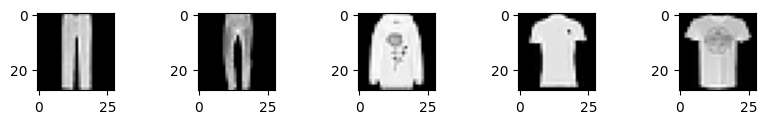

In [22]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 1))
for i in range(5):
    # Set the (i+1)st subplot in a plot with 5 images in 1 row.
    plt.subplot(1, 5, i+1)
    plt.imshow(X_train_tops_trousers_pullovers[i], cmap="gray")
print('label for each of the above image: %s' % (y_train_tops_trousers_pullovers[0:5]))

In [23]:
X_train_90_7_3, y_train_90_7_3 = resample(X_train_normalized, y_train_tops_trousers_pullovers, {0: 90, 1: 7, 2: 3})
X_test_90_7_3, y_test_90_7_3 = resample(X_test_normalized, y_test_tops_trousers_pullovers, {0: 90, 1: 7, 2: 3})
X_val_90_7_3, y_val_90_7_3 = resample(X_val_normalized, y_val_tops_trousers_pullovers, {0: 90, 1: 7, 2: 3})

X_train_80_15_5, y_train_80_15_5 = resample(X_train_normalized, y_train_tops_trousers_pullovers, {0: 80, 1: 15, 2: 5})
X_test_80_15_5, y_test_80_15_5 = resample(X_test_normalized, y_test_tops_trousers_pullovers, {0: 80, 1: 15, 2: 5})
X_val_80_15_5, y_val_80_15_5 = resample(X_val_normalized, y_val_tops_trousers_pullovers, {0: 80, 1: 15, 2: 5})

X_train_70_20_10, y_train_70_20_10 = resample(X_train_normalized, y_train_tops_trousers_pullovers, {0: 70, 1: 20, 2: 10})
X_test_70_20_10, y_test_70_20_10 = resample(X_test_normalized, y_test_tops_trousers_pullovers, {0: 70, 1: 20, 2: 10})
X_val_70_20_10, y_val_70_20_10 = resample(X_val_normalized, y_val_tops_trousers_pullovers, {0: 70, 1: 20, 2: 10})

X_train_60_30_10, y_train_60_30_10 = resample(X_train_normalized, y_train_tops_trousers_pullovers, {0: 60, 1: 30, 2: 10})
X_test_60_30_10, y_test_60_30_10 = resample(X_test_normalized, y_test_tops_trousers_pullovers, {0: 60, 1: 30, 2: 10})
X_val_60_30_10, y_val_60_30_10 = resample(X_val_normalized, y_val_tops_trousers_pullovers, {0: 60, 1: 30, 2: 10})

In [24]:
num_classes = 3

y_train_90_7_3_cat = to_categorical(y_train_90_7_3, num_classes)
y_test_90_7_3_cat = to_categorical(y_test_90_7_3, num_classes)
y_val_90_7_3_cat = to_categorical(y_val_90_7_3, num_classes)

y_train_80_15_5_cat = to_categorical(y_train_80_15_5, num_classes)
y_test_80_15_5_cat = to_categorical(y_test_80_15_5, num_classes)
y_val_80_15_5_cat = to_categorical(y_val_80_15_5, num_classes)

y_train_70_20_10_cat = to_categorical(y_train_70_20_10, num_classes)
y_test_70_20_10_cat = to_categorical(y_test_70_20_10, num_classes)
y_val_70_20_10_cat = to_categorical(y_val_70_20_10, num_classes)

y_train_60_30_10_cat = to_categorical(y_train_60_30_10, num_classes)
y_test_60_30_10_cat = to_categorical(y_test_60_30_10, num_classes)
y_val_60_30_10_cat = to_categorical(y_val_60_30_10, num_classes)

In [25]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam

# Intializing a sequential model
model_cnn = Sequential()

# Adding first conv layer with 64 filters and kernel size 3x3 , padding 'same' provides the output size same as the input size
# 64 filters produce 64 feature maps
# Input_shape denotes input image dimension of MNIST images
model_cnn.add(Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(28, 28, 1)))
# Adding max pooling to reduce the size of output of first conv layer
model_cnn.add(MaxPooling2D((2, 2), padding = 'same'))

model_cnn.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model_cnn.add(MaxPooling2D((2, 2), padding = 'same'))

model_cnn.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model_cnn.add(MaxPooling2D((2, 2), padding = 'same'))

# flattening the output of the conv layer after max pooling to make it ready for creating dense connections
model_cnn.add(Flatten())

# Adding a fully connected dense layer with 100 neurons
model_cnn.add(Dense(100, activation='relu'))

# Adding the output layer with 1 neuron and activation functions as sigmoid since this is a binary-class classification problem
model_cnn.add(Dense(3, activation='softmax'))

# Need to save the initial weights to train each cnn from scratch
initial_weights = model_cnn.get_weights()

/usr/local/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [26]:
# I need a multiclass version of my loss functions
# [2]

import tensorflow as tf

import tensorflow as tf

def multiclass_pairwise_hinge_loss(margin=1.0):
    margin = float(margin)

    def loss_fn(y_true, y_pred):
        # y_true may be one-hot or integer labels
        y_true = tf.cast(y_true, tf.float32)

        # If one-hot, convert to integer labels
        if y_true.shape.rank > 1:
            y_true_int = tf.argmax(y_true, axis=-1)
        else:
            y_true_int = tf.cast(tf.reshape(y_true, [-1]), tf.int32)

        # ---- 2) Convert probabilities → pseudo-logits ----
        # Clip to avoid log(0)
        probs = tf.clip_by_value(tf.cast(y_pred, tf.float32), 1e-9, 1.0)
        logits = tf.math.log(probs)  # shape (B, C)
        # (optionally, you could subtract max per row to center, but not required)

        # ---- 3) Crammer–Singer hinge using logits ----
        batch_size = tf.shape(logits)[0]
        num_classes = tf.shape(logits)[1]
        batch_indices = tf.range(batch_size)
        true_scores = tf.gather_nd(
            logits,
            tf.stack([batch_indices, tf.cast(y_true_int, tf.int32)], axis=1)
        )                               # (B,)
        true_scores = tf.reshape(true_scores, [-1, 1])  # (B, 1)

        # Mask out the true class
        one_hot = tf.one_hot(y_true_int, num_classes)   # (B, C)
        other_scores = logits - 1e9 * one_hot           # huge negative on true class

        # Max score among incorrect classes
        max_other = tf.reduce_max(other_scores, axis=1, keepdims=True)  # (B, 1)

        # hinge: max(0, margin - (true - max_other))
        violations = margin - (true_scores - max_other)
        losses = tf.nn.relu(violations)

        return tf.reduce_mean(losses)

    return loss_fn

In [27]:
def multiclass_balanced_accuracy_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.clip_by_value(tf.cast(y_pred,tf.float32), 1e-7, 1-1e-7)

    tp = tf.reduce_sum(y_true * y_pred, axis=0)
    fn = tf.reduce_sum(y_true * (1 - y_pred), axis=0)

    recall = tp / (tp + fn + 1e-7)
    macro_recall = tf.reduce_mean(recall)

    return 1 - macro_recall

In [28]:
def multiclass_f1_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    tp = tf.reduce_sum(y_true * y_pred, axis=0)
    fp = tf.reduce_sum((1 - y_true) * y_pred, axis=0)
    fn = tf.reduce_sum(y_true * (1 - y_pred), axis=0)

    f1 = (2 * tp) / (2 * tp + fp + fn + 1e-7)
    macro_f1 = tf.reduce_mean(f1)
    return 1 - macro_f1

In [29]:
# I also need a multi-class threshold tuning function
# this is non-trivial: 
# one option is to design a sort of decision tree where first I check if the probability of class A is above a threshold found for class A then if 
# this probability is below its threshold, I check for class B and so on
# another option is to find a universal set of thresholds for all classes (in a dict structure or something like that), and then check which classes
# are above their thresholds at the same time - the issue with this is that you might get one class thats way below its threshold and multiple classes
# that are above their threshold - in this case you'd have to come up with a method for choosing a single class - I would probably either do this by
# comparing the absolute difference between each softmax and theshold (softmax-theshold) or by comparing the percentage difference between softmax 
# and threshold (softmax/threshold)
# I will try each of these

from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import itertools

# this will be my decision tree threshold
def multiclass_tune_heuristic_threshold(X_val, y_val, model):
    depths=[1, 2, 3, 4]
    y_labels = np.argmax(y_val, axis=1)
    output_probs = model.predict(X_val)

    X_threshold_train, X_threshold_tune, y_threshold_train, y_threshold_tune = train_test_split(
        output_probs, y_labels, test_size=0.4, random_state=6, stratify=y_val
    )

    best_depth = None
    best_accuracy = -1.0

    for depth in depths:
        tree = DecisionTreeClassifier(criterion='gini', max_depth=depth, random_state=6)
        tree.fit(X_threshold_train, y_threshold_train)

        preds = tree.predict(X_threshold_tune)
        score = accuracy_score(y_threshold_tune, preds)

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_depth = depth

    best_tree = DecisionTreeClassifier(criterion='gini', max_depth=best_depth, random_state=6)
    best_tree.fit(output_probs, y_labels)

    return best_accuracy, best_tree

# this will get all of the combinations of thesholds which sum to 1 which will be useful for the next two tuning functions
def get_threshold_set(num_classes):
    thresholds = np.linspace(0, 1 - 1e-9, 20)
    thresholds_set = []

    for combo in itertools.product(thresholds, repeat=num_classes-1):
        s = sum(combo)
        last = 1 - s
        if 0 <= last <= 1 - 1e-9:
            thresholds_set.append(np.array(list(combo) + [last]))

    return thresholds_set

# this will be the unversal set of decision thresholds which handles tie breakers using absolute difference
def multiclass_tune_universal_absolute_threshold(X_val, y_val, model):
    output_probs = model.predict(X_val)
    num_classes = y_val.shape[-1]
    thresholds_set = get_threshold_set(num_classes)
    best_accuracy = -1
    best_threshold = thresholds_set[0]
    for threshold in thresholds_set:
        mask = (output_probs >= threshold).astype(int)
        candidates = mask * output_probs
        absolute_diff = candidates - threshold
        preds = np.argmax(absolute_diff, axis=1)
        y_val_label = y_val.argmax(axis=1)
        accuracy = accuracy_score(y_val_label, preds)
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_threshold = threshold

    return best_accuracy, best_threshold
        

def multiclass_tune_universal_relative_threshold(X_val, y_val, model):
    output_probs = model.predict(X_val)
    num_classes = y_val.shape[-1]
    thresholds_set = get_threshold_set(num_classes)
    best_accuracy = -1
    best_threshold = thresholds_set[0]
    for threshold in thresholds_set:
        mask = (output_probs >= threshold).astype(int)
        candidates = mask * output_probs
        absolute_diff = candidates / (threshold + 1e-9)
        preds = np.argmax(absolute_diff, axis=1)
        y_val_label = y_val.argmax(axis=1)
        accuracy = accuracy_score(y_val_label, preds)
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_threshold = threshold

    return best_accuracy, best_threshold

In [30]:
# and a multiclass pipeline

from sklearn.metrics import accuracy_score

def multiclass_train_tune_test_pipeline(model, X_train, y_train, X_val, y_val, X_test, y_test, loss_name, loss_fn, tune_name, tune_fn, split):
    model.set_weights(initial_weights)
    model.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])
    model.summary()
    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=128, verbose=2)
    best_accuracy, best_threshold = tune_fn(X_val, y_val, model)
    y_test_label = y_test.argmax(axis=1)
    test_probs = model.predict(X_test)
    if tune_name == "decision tree":
        preds = best_threshold.predict(test_probs)
    elif tune_name == "threshold absolute difference":
        mask = (test_probs >= best_threshold).astype(int)
        candidates = mask * test_probs
        absolute_diff = candidates - best_threshold
        preds = np.argmax(absolute_diff, axis=1)
    else:
        mask = (test_probs >= best_threshold).astype(int)
        candidates = mask * test_probs
        absolute_diff = candidates / (best_threshold + 1e-9)
        preds = np.argmax(absolute_diff, axis=1)
    accuracy = accuracy_score(y_test_label, preds)
    no_tuning_preds = np.argmax(test_probs, axis=1).astype(int)
    no_tuning_accuracy = accuracy_score(y_test_label, no_tuning_preds)
    print("Using:", loss_name, "and", tune_name, "on:", split)
    print("test accuracy:", accuracy, "using best threshold:", best_threshold)
    print("with argmax threshold:", no_tuning_accuracy)
    return accuracy, best_threshold, no_tuning_accuracy

In [31]:
# Now I'll run my pipeline

data_splits = {
    "90_7_3": {
        "X_train": X_train_90_7_3,
        "y_train": y_train_90_7_3_cat,
        "X_val":   X_val_90_7_3,
        "y_val":   y_val_90_7_3_cat,
        "X_test":  X_test_90_7_3,
        "y_test":  y_test_90_7_3_cat,
    },
    "80_15_5": {
        "X_train": X_train_80_15_5,
        "y_train": y_train_80_15_5_cat,
        "X_val":   X_val_80_15_5,
        "y_val":   y_val_80_15_5_cat,
        "X_test":  X_test_80_15_5,
        "y_test":  y_test_80_15_5_cat,
    },
    "70_20_10": {
        "X_train": X_train_70_20_10,
        "y_train": y_train_70_20_10_cat,
        "X_val":   X_val_70_20_10,
        "y_val":   y_val_70_20_10_cat,
        "X_test":  X_test_70_20_10,
        "y_test":  y_test_70_20_10_cat,
    },
    "60_30_10": {
        "X_train": X_train_60_30_10,
        "y_train": y_train_60_30_10_cat,
        "X_val":   X_val_60_30_10,
        "y_val":   y_val_60_30_10_cat,
        "X_test":  X_test_60_30_10,
        "y_test":  y_test_60_30_10_cat,
    },
}

loss_fns = {
    "categorical crossentropy": "categorical_crossentropy",
    "pairwise hinge loss (AUC-ROC surrogate)": multiclass_pairwise_hinge_loss(margin=1.0),
    "balanced accuracy loss": multiclass_balanced_accuracy_loss,
    "F1 loss": multiclass_f1_loss
}

tune_fns = {
    "decision tree": multiclass_tune_heuristic_threshold,
    "threshold absolute difference": multiclass_tune_universal_absolute_threshold,
    "threshold relative difference": multiclass_tune_universal_relative_threshold
}

splits = ["90_7_3", "80_15_5", "70_20_10", "60_30_10"]
results_multiclass = []

for split in splits:
    for loss_name, loss_fn in loss_fns.items():
        for tune_name, tune_fn in tune_fns.items():
            data = data_splits[split]
            accuracy, best_threshold, no_tuning_accuracy = multiclass_train_tune_test_pipeline(model_cnn,
                             data["X_train"], data["y_train"],
                             data["X_val"], data["y_val"],
                             data["X_test"], data["y_test"],
                             loss_name, loss_fn, tune_name, tune_fn, split)
            results_multiclass.append({
                "split": split,
                "loss": loss_name,
                "tuned using": tune_name,
                "best threshold": best_threshold,
                "best accuracy": accuracy,
                "accuracy using default softmax": no_tuning_accuracy,
            })

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │        51,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,955 (312.32 KB)

 Trainable params: 79,955 (312.32 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
38/38 - 3s - 81ms/step - accuracy: 0.9087 - loss: 0.3776 - val_accuracy: 0.9600 - val_loss: 0.1695
Epoch 2/10
38/38 - 2s - 41ms/step - accuracy: 0.9660 - loss: 0.1012 - val_accuracy: 0.9825 - val_loss: 0.0511
Epoch 3/10
38/38 - 1s - 39ms/step - accuracy: 0.9827 - loss: 0.0505 - val_accuracy: 0.9883 - val_loss: 0.0348
Epoch 4/10
38/38 - 2s - 41ms/step - accuracy: 0.9840 - loss: 0.0445 - val_accuracy: 0.9875 - val_loss: 0.0351
Epoch 5/10
38/38 - 2s - 40ms/step - accuracy: 0.9867 - loss: 0.0399 - val_accuracy: 0.9883 - val_loss: 0.0363
Epoch 6/10
38/38 - 2s - 40ms/step - accuracy: 0.9877 - loss: 0.0382 - val_accuracy: 0.9900 - val_loss: 0.0310
Epoch 7/10
38/38 - 2s - 40ms/step - accuracy: 0.9883 - loss: 0.0349 - val_accuracy: 0.9908 - val_loss: 0.0305
Epoch 8/10
38/38 - 2s - 41ms/step - accuracy: 0.9900 - loss: 0.0335 - val_accuracy: 0.9917 - val_loss: 0.0297
Epoch 9/10
38/38 - 3s - 68ms/step - accuracy: 0.9896 - loss: 0.0307 - val_accuracy: 0.9908 - val_loss: 0.0286
Epoch 10/1

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │        51,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,955 (312.32 KB)

 Trainable params: 79,955 (312.32 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
38/38 - 3s - 82ms/step - accuracy: 0.9087 - loss: 0.3787 - val_accuracy: 0.9608 - val_loss: 0.1760
Epoch 2/10
38/38 - 2s - 40ms/step - accuracy: 0.9681 - loss: 0.0966 - val_accuracy: 0.9775 - val_loss: 0.0539
Epoch 3/10
38/38 - 3s - 68ms/step - accuracy: 0.9812 - loss: 0.0547 - val_accuracy: 0.9883 - val_loss: 0.0350
Epoch 4/10
38/38 - 2s - 41ms/step - accuracy: 0.9862 - loss: 0.0420 - val_accuracy: 0.9858 - val_loss: 0.0369
Epoch 5/10
38/38 - 2s - 41ms/step - accuracy: 0.9881 - loss: 0.0395 - val_accuracy: 0.9833 - val_loss: 0.0438
Epoch 6/10
38/38 - 2s - 41ms/step - accuracy: 0.9885 - loss: 0.0365 - val_accuracy: 0.9900 - val_loss: 0.0309
Epoch 7/10
38/38 - 3s - 67ms/step - accuracy: 0.9885 - loss: 0.0346 - val_accuracy: 0.9900 - val_loss: 0.0318
Epoch 8/10
38/38 - 2s - 40ms/step - accuracy: 0.9906 - loss: 0.0327 - val_accuracy: 0.9883 - val_loss: 0.0302
Epoch 9/10
38/38 - 2s - 41ms/step - accuracy: 0.9904 - loss: 0.0287 - val_accuracy: 0.9892 - val_loss: 0.0311
Epoch 10/1

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │        51,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,955 (312.32 KB)

 Trainable params: 79,955 (312.32 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
38/38 - 3s - 79ms/step - accuracy: 0.9106 - loss: 0.3684 - val_accuracy: 0.9600 - val_loss: 0.1581
Epoch 2/10
38/38 - 2s - 40ms/step - accuracy: 0.9719 - loss: 0.0889 - val_accuracy: 0.9817 - val_loss: 0.0464
Epoch 3/10
38/38 - 2s - 40ms/step - accuracy: 0.9831 - loss: 0.0490 - val_accuracy: 0.9883 - val_loss: 0.0341
Epoch 4/10
38/38 - 2s - 41ms/step - accuracy: 0.9858 - loss: 0.0441 - val_accuracy: 0.9867 - val_loss: 0.0330
Epoch 5/10
38/38 - 2s - 41ms/step - accuracy: 0.9883 - loss: 0.0383 - val_accuracy: 0.9833 - val_loss: 0.0438
Epoch 6/10
38/38 - 2s - 40ms/step - accuracy: 0.9875 - loss: 0.0411 - val_accuracy: 0.9908 - val_loss: 0.0322
Epoch 7/10
38/38 - 2s - 41ms/step - accuracy: 0.9900 - loss: 0.0348 - val_accuracy: 0.9883 - val_loss: 0.0388
Epoch 8/10
38/38 - 2s - 41ms/step - accuracy: 0.9900 - loss: 0.0325 - val_accuracy: 0.9900 - val_loss: 0.0351
Epoch 9/10
38/38 - 2s - 41ms/step - accuracy: 0.9917 - loss: 0.0299 - val_accuracy: 0.9900 - val_loss: 0.0300
Epoch 10/1

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │        51,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,955 (312.32 KB)

 Trainable params: 79,955 (312.32 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
38/38 - 3s - 83ms/step - accuracy: 0.9081 - loss: 0.2774 - val_accuracy: 0.9592 - val_loss: 0.1095
Epoch 2/10
38/38 - 2s - 41ms/step - accuracy: 0.9681 - loss: 0.0768 - val_accuracy: 0.9858 - val_loss: 0.0423
Epoch 3/10
38/38 - 2s - 41ms/step - accuracy: 0.9829 - loss: 0.0444 - val_accuracy: 0.9858 - val_loss: 0.0353
Epoch 4/10
38/38 - 2s - 40ms/step - accuracy: 0.9860 - loss: 0.0357 - val_accuracy: 0.9908 - val_loss: 0.0261
Epoch 5/10
38/38 - 2s - 41ms/step - accuracy: 0.9883 - loss: 0.0313 - val_accuracy: 0.9900 - val_loss: 0.0294
Epoch 6/10
38/38 - 2s - 40ms/step - accuracy: 0.9885 - loss: 0.0301 - val_accuracy: 0.9900 - val_loss: 0.0239
Epoch 7/10
38/38 - 2s - 41ms/step - accuracy: 0.9896 - loss: 0.0278 - val_accuracy: 0.9908 - val_loss: 0.0241
Epoch 8/10
38/38 - 2s - 40ms/step - accuracy: 0.9915 - loss: 0.0251 - val_accuracy: 0.9900 - val_loss: 0.0225
Epoch 9/10
38/38 - 2s - 40ms/step - accuracy: 0.9923 - loss: 0.0210 - val_accuracy: 0.9908 - val_loss: 0.0238
Epoch 10/1

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │        51,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,955 (312.32 KB)

 Trainable params: 79,955 (312.32 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
38/38 - 3s - 85ms/step - accuracy: 0.9135 - loss: 0.2578 - val_accuracy: 0.9625 - val_loss: 0.0935
Epoch 2/10
38/38 - 2s - 42ms/step - accuracy: 0.9696 - loss: 0.0699 - val_accuracy: 0.9750 - val_loss: 0.0571
Epoch 3/10
38/38 - 2s - 41ms/step - accuracy: 0.9821 - loss: 0.0447 - val_accuracy: 0.9900 - val_loss: 0.0262
Epoch 4/10
38/38 - 2s - 41ms/step - accuracy: 0.9869 - loss: 0.0346 - val_accuracy: 0.9892 - val_loss: 0.0270
Epoch 5/10
38/38 - 2s - 40ms/step - accuracy: 0.9871 - loss: 0.0328 - val_accuracy: 0.9900 - val_loss: 0.0282
Epoch 6/10
38/38 - 2s - 40ms/step - accuracy: 0.9877 - loss: 0.0335 - val_accuracy: 0.9867 - val_loss: 0.0348
Epoch 7/10
38/38 - 1s - 39ms/step - accuracy: 0.9908 - loss: 0.0273 - val_accuracy: 0.9908 - val_loss: 0.0242
Epoch 8/10
38/38 - 2s - 40ms/step - accuracy: 0.9919 - loss: 0.0232 - val_accuracy: 0.9917 - val_loss: 0.0224
Epoch 9/10
38/38 - 2s - 41ms/step - accuracy: 0.9921 - loss: 0.0219 - val_accuracy: 0.9917 - val_loss: 0.0242
Epoch 10/1

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │        51,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,955 (312.32 KB)

 Trainable params: 79,955 (312.32 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
38/38 - 3s - 81ms/step - accuracy: 0.9104 - loss: 0.2693 - val_accuracy: 0.9633 - val_loss: 0.0990
Epoch 2/10
38/38 - 2s - 40ms/step - accuracy: 0.9700 - loss: 0.0724 - val_accuracy: 0.9842 - val_loss: 0.0456
Epoch 3/10
38/38 - 1s - 39ms/step - accuracy: 0.9831 - loss: 0.0425 - val_accuracy: 0.9875 - val_loss: 0.0290
Epoch 4/10
38/38 - 3s - 68ms/step - accuracy: 0.9862 - loss: 0.0375 - val_accuracy: 0.9892 - val_loss: 0.0317
Epoch 5/10
38/38 - 1s - 38ms/step - accuracy: 0.9873 - loss: 0.0313 - val_accuracy: 0.9908 - val_loss: 0.0244
Epoch 6/10
38/38 - 1s - 39ms/step - accuracy: 0.9904 - loss: 0.0274 - val_accuracy: 0.9892 - val_loss: 0.0254
Epoch 7/10
38/38 - 1s - 39ms/step - accuracy: 0.9908 - loss: 0.0271 - val_accuracy: 0.9900 - val_loss: 0.0231
Epoch 8/10
38/38 - 3s - 66ms/step - accuracy: 0.9910 - loss: 0.0244 - val_accuracy: 0.9908 - val_loss: 0.0279
Epoch 9/10
38/38 - 1s - 38ms/step - accuracy: 0.9923 - loss: 0.0225 - val_accuracy: 0.9900 - val_loss: 0.0262
Epoch 10/1

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │        51,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,955 (312.32 KB)

 Trainable params: 79,955 (312.32 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
38/38 - 3s - 79ms/step - accuracy: 0.7417 - loss: 0.2836 - val_accuracy: 0.8642 - val_loss: 0.0943
Epoch 2/10
38/38 - 1s - 39ms/step - accuracy: 0.8646 - loss: 0.1020 - val_accuracy: 0.9475 - val_loss: 0.0733
Epoch 3/10
38/38 - 1s - 38ms/step - accuracy: 0.9058 - loss: 0.0786 - val_accuracy: 0.9467 - val_loss: 0.0630
Epoch 4/10
38/38 - 1s - 38ms/step - accuracy: 0.9235 - loss: 0.0806 - val_accuracy: 0.9700 - val_loss: 0.0606
Epoch 5/10
38/38 - 1s - 38ms/step - accuracy: 0.9606 - loss: 0.0430 - val_accuracy: 0.9700 - val_loss: 0.0527
Epoch 6/10
38/38 - 1s - 39ms/step - accuracy: 0.9550 - loss: 0.0493 - val_accuracy: 0.9300 - val_loss: 0.0632
Epoch 7/10
38/38 - 3s - 67ms/step - accuracy: 0.9287 - loss: 0.0624 - val_accuracy: 0.9375 - val_loss: 0.0591
Epoch 8/10
38/38 - 1s - 39ms/step - accuracy: 0.9375 - loss: 0.0560 - val_accuracy: 0.9567 - val_loss: 0.0582
Epoch 9/10
38/38 - 1s - 38ms/step - accuracy: 0.9413 - loss: 0.0473 - val_accuracy: 0.9133 - val_loss: 0.0713
Epoch 10/1

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │        51,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,955 (312.32 KB)

 Trainable params: 79,955 (312.32 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
38/38 - 3s - 79ms/step - accuracy: 0.6712 - loss: 0.2680 - val_accuracy: 0.8975 - val_loss: 0.0870
Epoch 2/10
38/38 - 1s - 39ms/step - accuracy: 0.8827 - loss: 0.0781 - val_accuracy: 0.9475 - val_loss: 0.0683
Epoch 3/10
38/38 - 2s - 40ms/step - accuracy: 0.9223 - loss: 0.0671 - val_accuracy: 0.9467 - val_loss: 0.0692
Epoch 4/10
38/38 - 1s - 39ms/step - accuracy: 0.9273 - loss: 0.0545 - val_accuracy: 0.9717 - val_loss: 0.0773
Epoch 5/10
38/38 - 3s - 66ms/step - accuracy: 0.9458 - loss: 0.0432 - val_accuracy: 0.9675 - val_loss: 0.0500
Epoch 6/10
38/38 - 1s - 39ms/step - accuracy: 0.9654 - loss: 0.0388 - val_accuracy: 0.9808 - val_loss: 0.0546
Epoch 7/10
38/38 - 2s - 40ms/step - accuracy: 0.9494 - loss: 0.0371 - val_accuracy: 0.9458 - val_loss: 0.0635
Epoch 8/10
38/38 - 2s - 40ms/step - accuracy: 0.9527 - loss: 0.0410 - val_accuracy: 0.9517 - val_loss: 0.0494
Epoch 9/10
38/38 - 1s - 39ms/step - accuracy: 0.9479 - loss: 0.0402 - val_accuracy: 0.9725 - val_loss: 0.0440
Epoch 10/1

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │        51,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,955 (312.32 KB)

 Trainable params: 79,955 (312.32 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
38/38 - 3s - 80ms/step - accuracy: 0.6523 - loss: 0.2798 - val_accuracy: 0.8250 - val_loss: 0.1048
Epoch 2/10
38/38 - 1s - 39ms/step - accuracy: 0.8998 - loss: 0.0726 - val_accuracy: 0.9542 - val_loss: 0.0717
Epoch 3/10
38/38 - 2s - 40ms/step - accuracy: 0.9108 - loss: 0.0765 - val_accuracy: 0.9833 - val_loss: 0.0859
Epoch 4/10
38/38 - 2s - 40ms/step - accuracy: 0.9502 - loss: 0.0637 - val_accuracy: 0.9400 - val_loss: 0.0563
Epoch 5/10
38/38 - 2s - 40ms/step - accuracy: 0.9479 - loss: 0.0598 - val_accuracy: 0.9817 - val_loss: 0.0553
Epoch 6/10
38/38 - 2s - 40ms/step - accuracy: 0.9377 - loss: 0.0602 - val_accuracy: 0.9433 - val_loss: 0.0681
Epoch 7/10
38/38 - 1s - 39ms/step - accuracy: 0.9527 - loss: 0.0476 - val_accuracy: 0.8667 - val_loss: 0.0883
Epoch 8/10
38/38 - 1s - 39ms/step - accuracy: 0.9448 - loss: 0.0517 - val_accuracy: 0.9433 - val_loss: 0.0526
Epoch 9/10
38/38 - 1s - 39ms/step - accuracy: 0.9594 - loss: 0.0386 - val_accuracy: 0.9658 - val_loss: 0.0469
Epoch 10/1

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │        51,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,955 (312.32 KB)

 Trainable params: 79,955 (312.32 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
38/38 - 3s - 81ms/step - accuracy: 0.9265 - loss: 0.5112 - val_accuracy: 0.9558 - val_loss: 0.3892
Epoch 2/10
38/38 - 2s - 40ms/step - accuracy: 0.9583 - loss: 0.3735 - val_accuracy: 0.9625 - val_loss: 0.3723
Epoch 3/10
38/38 - 1s - 39ms/step - accuracy: 0.9602 - loss: 0.3679 - val_accuracy: 0.9667 - val_loss: 0.3645
Epoch 4/10
38/38 - 1s - 39ms/step - accuracy: 0.9660 - loss: 0.3514 - val_accuracy: 0.9667 - val_loss: 0.3637
Epoch 5/10
38/38 - 1s - 39ms/step - accuracy: 0.9623 - loss: 0.3640 - val_accuracy: 0.9667 - val_loss: 0.3611
Epoch 6/10
38/38 - 1s - 39ms/step - accuracy: 0.9665 - loss: 0.3503 - val_accuracy: 0.9658 - val_loss: 0.3632
Epoch 7/10
38/38 - 1s - 39ms/step - accuracy: 0.9663 - loss: 0.3548 - val_accuracy: 0.9658 - val_loss: 0.3623
Epoch 8/10
38/38 - 3s - 66ms/step - accuracy: 0.9669 - loss: 0.3480 - val_accuracy: 0.9667 - val_loss: 0.3616
Epoch 9/10
38/38 - 1s - 38ms/step - accuracy: 0.9669 - loss: 0.3472 - val_accuracy: 0.9625 - val_loss: 0.3685
Epoch 10/1

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │        51,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,955 (312.32 KB)

 Trainable params: 79,955 (312.32 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
38/38 - 3s - 81ms/step - accuracy: 0.9271 - loss: 0.5104 - val_accuracy: 0.9592 - val_loss: 0.3814
Epoch 2/10
38/38 - 1s - 39ms/step - accuracy: 0.9579 - loss: 0.3732 - val_accuracy: 0.9625 - val_loss: 0.3698
Epoch 3/10
38/38 - 1s - 38ms/step - accuracy: 0.9633 - loss: 0.3585 - val_accuracy: 0.9650 - val_loss: 0.3673
Epoch 4/10
38/38 - 1s - 38ms/step - accuracy: 0.9650 - loss: 0.3533 - val_accuracy: 0.9667 - val_loss: 0.3647
Epoch 5/10
38/38 - 1s - 39ms/step - accuracy: 0.9656 - loss: 0.3503 - val_accuracy: 0.9650 - val_loss: 0.3656
Epoch 6/10
38/38 - 1s - 38ms/step - accuracy: 0.9642 - loss: 0.3571 - val_accuracy: 0.9650 - val_loss: 0.3644
Epoch 7/10
38/38 - 1s - 39ms/step - accuracy: 0.9671 - loss: 0.3459 - val_accuracy: 0.9642 - val_loss: 0.3661
Epoch 8/10
38/38 - 1s - 39ms/step - accuracy: 0.9673 - loss: 0.3462 - val_accuracy: 0.9650 - val_loss: 0.3673
Epoch 9/10
38/38 - 1s - 39ms/step - accuracy: 0.9671 - loss: 0.3479 - val_accuracy: 0.9650 - val_loss: 0.3647
Epoch 10/1

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │        51,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,955 (312.32 KB)

 Trainable params: 79,955 (312.32 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
38/38 - 4s - 105ms/step - accuracy: 0.9285 - loss: 0.5126 - val_accuracy: 0.9583 - val_loss: 0.3840
Epoch 2/10
38/38 - 1s - 39ms/step - accuracy: 0.9575 - loss: 0.3771 - val_accuracy: 0.9625 - val_loss: 0.3710
Epoch 3/10
38/38 - 1s - 39ms/step - accuracy: 0.9633 - loss: 0.3560 - val_accuracy: 0.9642 - val_loss: 0.3665
Epoch 4/10
38/38 - 1s - 38ms/step - accuracy: 0.9648 - loss: 0.3572 - val_accuracy: 0.9658 - val_loss: 0.3630
Epoch 5/10
38/38 - 1s - 38ms/step - accuracy: 0.9654 - loss: 0.3533 - val_accuracy: 0.9658 - val_loss: 0.3625
Epoch 6/10
38/38 - 1s - 38ms/step - accuracy: 0.9660 - loss: 0.3501 - val_accuracy: 0.9658 - val_loss: 0.3643
Epoch 7/10
38/38 - 1s - 39ms/step - accuracy: 0.9669 - loss: 0.3490 - val_accuracy: 0.9642 - val_loss: 0.3659
Epoch 8/10
38/38 - 2s - 66ms/step - accuracy: 0.9677 - loss: 0.3456 - val_accuracy: 0.9650 - val_loss: 0.3641
Epoch 9/10
38/38 - 1s - 39ms/step - accuracy: 0.9671 - loss: 0.3472 - val_accuracy: 0.9658 - val_loss: 0.3632
Epoch 10/

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │        51,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,955 (312.32 KB)

 Trainable params: 79,955 (312.32 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
38/38 - 3s - 83ms/step - accuracy: 0.8769 - loss: 0.4380 - val_accuracy: 0.9592 - val_loss: 0.1287
Epoch 2/10
38/38 - 2s - 40ms/step - accuracy: 0.9652 - loss: 0.0920 - val_accuracy: 0.9750 - val_loss: 0.0699
Epoch 3/10
38/38 - 1s - 38ms/step - accuracy: 0.9796 - loss: 0.0646 - val_accuracy: 0.9842 - val_loss: 0.0475
Epoch 4/10
38/38 - 1s - 39ms/step - accuracy: 0.9829 - loss: 0.0539 - val_accuracy: 0.9825 - val_loss: 0.0489
Epoch 5/10
38/38 - 1s - 39ms/step - accuracy: 0.9815 - loss: 0.0517 - val_accuracy: 0.9850 - val_loss: 0.0417
Epoch 6/10
38/38 - 2s - 40ms/step - accuracy: 0.9852 - loss: 0.0457 - val_accuracy: 0.9858 - val_loss: 0.0408
Epoch 7/10
38/38 - 1s - 39ms/step - accuracy: 0.9854 - loss: 0.0457 - val_accuracy: 0.9833 - val_loss: 0.0492
Epoch 8/10
38/38 - 1s - 39ms/step - accuracy: 0.9869 - loss: 0.0397 - val_accuracy: 0.9867 - val_loss: 0.0365
Epoch 9/10
38/38 - 1s - 39ms/step - accuracy: 0.9885 - loss: 0.0365 - val_accuracy: 0.9867 - val_loss: 0.0362
Epoch 10/1

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │        51,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,955 (312.32 KB)

 Trainable params: 79,955 (312.32 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
38/38 - 3s - 83ms/step - accuracy: 0.8717 - loss: 0.4766 - val_accuracy: 0.9350 - val_loss: 0.1730
Epoch 2/10
38/38 - 1s - 39ms/step - accuracy: 0.9602 - loss: 0.1060 - val_accuracy: 0.9783 - val_loss: 0.0588
Epoch 3/10
38/38 - 1s - 38ms/step - accuracy: 0.9800 - loss: 0.0611 - val_accuracy: 0.9842 - val_loss: 0.0467
Epoch 4/10
38/38 - 1s - 39ms/step - accuracy: 0.9821 - loss: 0.0551 - val_accuracy: 0.9775 - val_loss: 0.0580
Epoch 5/10
38/38 - 1s - 38ms/step - accuracy: 0.9840 - loss: 0.0496 - val_accuracy: 0.9833 - val_loss: 0.0487
Epoch 6/10
38/38 - 1s - 39ms/step - accuracy: 0.9844 - loss: 0.0494 - val_accuracy: 0.9833 - val_loss: 0.0437
Epoch 7/10
38/38 - 1s - 39ms/step - accuracy: 0.9852 - loss: 0.0434 - val_accuracy: 0.9850 - val_loss: 0.0406
Epoch 8/10
38/38 - 1s - 38ms/step - accuracy: 0.9875 - loss: 0.0399 - val_accuracy: 0.9850 - val_loss: 0.0385
Epoch 9/10
38/38 - 1s - 39ms/step - accuracy: 0.9862 - loss: 0.0417 - val_accuracy: 0.9867 - val_loss: 0.0390
Epoch 10/1

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │        51,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,955 (312.32 KB)

 Trainable params: 79,955 (312.32 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
38/38 - 3s - 80ms/step - accuracy: 0.8794 - loss: 0.4383 - val_accuracy: 0.9642 - val_loss: 0.1361
Epoch 2/10
38/38 - 1s - 38ms/step - accuracy: 0.9638 - loss: 0.0937 - val_accuracy: 0.9783 - val_loss: 0.0620
Epoch 3/10
38/38 - 1s - 38ms/step - accuracy: 0.9790 - loss: 0.0593 - val_accuracy: 0.9825 - val_loss: 0.0491
Epoch 4/10
38/38 - 1s - 38ms/step - accuracy: 0.9819 - loss: 0.0537 - val_accuracy: 0.9817 - val_loss: 0.0494
Epoch 5/10
38/38 - 1s - 38ms/step - accuracy: 0.9846 - loss: 0.0511 - val_accuracy: 0.9858 - val_loss: 0.0450
Epoch 6/10
38/38 - 1s - 38ms/step - accuracy: 0.9858 - loss: 0.0461 - val_accuracy: 0.9850 - val_loss: 0.0407
Epoch 7/10
38/38 - 1s - 38ms/step - accuracy: 0.9846 - loss: 0.0443 - val_accuracy: 0.9800 - val_loss: 0.0627
Epoch 8/10
38/38 - 1s - 39ms/step - accuracy: 0.9825 - loss: 0.0485 - val_accuracy: 0.9825 - val_loss: 0.0489
Epoch 9/10
38/38 - 2s - 40ms/step - accuracy: 0.9869 - loss: 0.0419 - val_accuracy: 0.9858 - val_loss: 0.0369
Epoch 10/1

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │        51,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,955 (312.32 KB)

 Trainable params: 79,955 (312.32 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
38/38 - 3s - 78ms/step - accuracy: 0.8860 - loss: 0.3100 - val_accuracy: 0.9408 - val_loss: 0.1109
Epoch 2/10
38/38 - 1s - 39ms/step - accuracy: 0.9698 - loss: 0.0826 - val_accuracy: 0.9808 - val_loss: 0.0509
Epoch 3/10
38/38 - 2s - 40ms/step - accuracy: 0.9794 - loss: 0.0547 - val_accuracy: 0.9850 - val_loss: 0.0399
Epoch 4/10
38/38 - 1s - 39ms/step - accuracy: 0.9850 - loss: 0.0438 - val_accuracy: 0.9875 - val_loss: 0.0386
Epoch 5/10
38/38 - 2s - 39ms/step - accuracy: 0.9865 - loss: 0.0396 - val_accuracy: 0.9858 - val_loss: 0.0326
Epoch 6/10
38/38 - 2s - 40ms/step - accuracy: 0.9869 - loss: 0.0357 - val_accuracy: 0.9908 - val_loss: 0.0354
Epoch 7/10
38/38 - 1s - 39ms/step - accuracy: 0.9883 - loss: 0.0332 - val_accuracy: 0.9858 - val_loss: 0.0319
Epoch 8/10
38/38 - 1s - 38ms/step - accuracy: 0.9890 - loss: 0.0304 - val_accuracy: 0.9883 - val_loss: 0.0293
Epoch 9/10
38/38 - 1s - 38ms/step - accuracy: 0.9904 - loss: 0.0283 - val_accuracy: 0.9892 - val_loss: 0.0295
Epoch 10/1

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │        51,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,955 (312.32 KB)

 Trainable params: 79,955 (312.32 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
38/38 - 3s - 80ms/step - accuracy: 0.8858 - loss: 0.3089 - val_accuracy: 0.9625 - val_loss: 0.0944
Epoch 2/10
38/38 - 2s - 41ms/step - accuracy: 0.9725 - loss: 0.0704 - val_accuracy: 0.9800 - val_loss: 0.0609
Epoch 3/10
38/38 - 1s - 39ms/step - accuracy: 0.9777 - loss: 0.0600 - val_accuracy: 0.9842 - val_loss: 0.0410
Epoch 4/10
38/38 - 1s - 38ms/step - accuracy: 0.9860 - loss: 0.0426 - val_accuracy: 0.9833 - val_loss: 0.0440
Epoch 5/10
38/38 - 1s - 38ms/step - accuracy: 0.9856 - loss: 0.0395 - val_accuracy: 0.9875 - val_loss: 0.0354
Epoch 6/10
38/38 - 1s - 37ms/step - accuracy: 0.9879 - loss: 0.0352 - val_accuracy: 0.9867 - val_loss: 0.0351
Epoch 7/10
38/38 - 1s - 39ms/step - accuracy: 0.9881 - loss: 0.0338 - val_accuracy: 0.9875 - val_loss: 0.0452
Epoch 8/10
38/38 - 1s - 38ms/step - accuracy: 0.9892 - loss: 0.0360 - val_accuracy: 0.9842 - val_loss: 0.0381
Epoch 9/10
38/38 - 1s - 39ms/step - accuracy: 0.9877 - loss: 0.0304 - val_accuracy: 0.9883 - val_loss: 0.0320
Epoch 10/1

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │        51,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,955 (312.32 KB)

 Trainable params: 79,955 (312.32 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
38/38 - 3s - 81ms/step - accuracy: 0.8833 - loss: 0.3263 - val_accuracy: 0.9475 - val_loss: 0.1013
Epoch 2/10
38/38 - 2s - 40ms/step - accuracy: 0.9704 - loss: 0.0744 - val_accuracy: 0.9825 - val_loss: 0.0467
Epoch 3/10
38/38 - 2s - 40ms/step - accuracy: 0.9800 - loss: 0.0528 - val_accuracy: 0.9850 - val_loss: 0.0391
Epoch 4/10
38/38 - 2s - 40ms/step - accuracy: 0.9844 - loss: 0.0431 - val_accuracy: 0.9858 - val_loss: 0.0354
Epoch 5/10
38/38 - 1s - 38ms/step - accuracy: 0.9869 - loss: 0.0384 - val_accuracy: 0.9875 - val_loss: 0.0336
Epoch 6/10
38/38 - 1s - 39ms/step - accuracy: 0.9865 - loss: 0.0374 - val_accuracy: 0.9892 - val_loss: 0.0317
Epoch 7/10
38/38 - 2s - 40ms/step - accuracy: 0.9883 - loss: 0.0338 - val_accuracy: 0.9900 - val_loss: 0.0341
Epoch 8/10
38/38 - 1s - 38ms/step - accuracy: 0.9881 - loss: 0.0319 - val_accuracy: 0.9908 - val_loss: 0.0298
Epoch 9/10
38/38 - 1s - 38ms/step - accuracy: 0.9894 - loss: 0.0281 - val_accuracy: 0.9900 - val_loss: 0.0308
Epoch 10/1

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │        51,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,955 (312.32 KB)

 Trainable params: 79,955 (312.32 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
38/38 - 3s - 82ms/step - accuracy: 0.7237 - loss: 0.2529 - val_accuracy: 0.9258 - val_loss: 0.0766
Epoch 2/10
38/38 - 2s - 40ms/step - accuracy: 0.8990 - loss: 0.0712 - val_accuracy: 0.9300 - val_loss: 0.0656
Epoch 3/10
38/38 - 2s - 40ms/step - accuracy: 0.9423 - loss: 0.0480 - val_accuracy: 0.9225 - val_loss: 0.0612
Epoch 4/10
38/38 - 1s - 39ms/step - accuracy: 0.9352 - loss: 0.0462 - val_accuracy: 0.9517 - val_loss: 0.0668
Epoch 5/10
38/38 - 2s - 40ms/step - accuracy: 0.9615 - loss: 0.0379 - val_accuracy: 0.9492 - val_loss: 0.0581
Epoch 6/10
38/38 - 2s - 40ms/step - accuracy: 0.9725 - loss: 0.0279 - val_accuracy: 0.9675 - val_loss: 0.0448
Epoch 7/10
38/38 - 1s - 39ms/step - accuracy: 0.9646 - loss: 0.0275 - val_accuracy: 0.9725 - val_loss: 0.0420
Epoch 8/10
38/38 - 1s - 39ms/step - accuracy: 0.9563 - loss: 0.0288 - val_accuracy: 0.9467 - val_loss: 0.0437
Epoch 9/10
38/38 - 2s - 41ms/step - accuracy: 0.9652 - loss: 0.0294 - val_accuracy: 0.9350 - val_loss: 0.0500
Epoch 10/1

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │        51,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,955 (312.32 KB)

 Trainable params: 79,955 (312.32 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
38/38 - 3s - 82ms/step - accuracy: 0.6781 - loss: 0.2590 - val_accuracy: 0.8875 - val_loss: 0.0848
Epoch 2/10
38/38 - 2s - 40ms/step - accuracy: 0.9096 - loss: 0.0768 - val_accuracy: 0.9050 - val_loss: 0.0739
Epoch 3/10
38/38 - 2s - 40ms/step - accuracy: 0.9269 - loss: 0.0686 - val_accuracy: 0.9417 - val_loss: 0.0590
Epoch 4/10
38/38 - 2s - 40ms/step - accuracy: 0.9444 - loss: 0.0435 - val_accuracy: 0.9033 - val_loss: 0.0687
Epoch 5/10
38/38 - 2s - 41ms/step - accuracy: 0.9538 - loss: 0.0403 - val_accuracy: 0.9558 - val_loss: 0.0560
Epoch 6/10
38/38 - 1s - 39ms/step - accuracy: 0.9598 - loss: 0.0322 - val_accuracy: 0.9525 - val_loss: 0.0507
Epoch 7/10
38/38 - 1s - 39ms/step - accuracy: 0.9685 - loss: 0.0257 - val_accuracy: 0.9625 - val_loss: 0.0441
Epoch 8/10
38/38 - 1s - 39ms/step - accuracy: 0.9617 - loss: 0.0317 - val_accuracy: 0.9792 - val_loss: 0.0602
Epoch 9/10
38/38 - 2s - 40ms/step - accuracy: 0.9638 - loss: 0.0269 - val_accuracy: 0.9400 - val_loss: 0.0454
Epoch 10/1

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │        51,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,955 (312.32 KB)

 Trainable params: 79,955 (312.32 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
38/38 - 3s - 79ms/step - accuracy: 0.7873 - loss: 0.2495 - val_accuracy: 0.8383 - val_loss: 0.1033
Epoch 2/10
38/38 - 2s - 40ms/step - accuracy: 0.8988 - loss: 0.0716 - val_accuracy: 0.9467 - val_loss: 0.0666
Epoch 3/10
38/38 - 2s - 40ms/step - accuracy: 0.9450 - loss: 0.0542 - val_accuracy: 0.9442 - val_loss: 0.0480
Epoch 4/10
38/38 - 1s - 38ms/step - accuracy: 0.9579 - loss: 0.0370 - val_accuracy: 0.9617 - val_loss: 0.0474
Epoch 5/10
38/38 - 1s - 39ms/step - accuracy: 0.9463 - loss: 0.0387 - val_accuracy: 0.9358 - val_loss: 0.0485
Epoch 6/10
38/38 - 2s - 41ms/step - accuracy: 0.9558 - loss: 0.0308 - val_accuracy: 0.9567 - val_loss: 0.0467
Epoch 7/10
38/38 - 1s - 39ms/step - accuracy: 0.9640 - loss: 0.0280 - val_accuracy: 0.9583 - val_loss: 0.0423
Epoch 8/10
38/38 - 1s - 39ms/step - accuracy: 0.9712 - loss: 0.0220 - val_accuracy: 0.9717 - val_loss: 0.0378
Epoch 9/10
38/38 - 1s - 39ms/step - accuracy: 0.9748 - loss: 0.0230 - val_accuracy: 0.9692 - val_loss: 0.0351
Epoch 10/1

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │        51,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,955 (312.32 KB)

 Trainable params: 79,955 (312.32 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
38/38 - 3s - 80ms/step - accuracy: 0.8873 - loss: 0.4752 - val_accuracy: 0.9308 - val_loss: 0.3730
Epoch 2/10
38/38 - 1s - 39ms/step - accuracy: 0.9310 - loss: 0.3729 - val_accuracy: 0.9333 - val_loss: 0.3697
Epoch 3/10
38/38 - 1s - 39ms/step - accuracy: 0.9371 - loss: 0.3610 - val_accuracy: 0.9417 - val_loss: 0.3578
Epoch 4/10
38/38 - 2s - 40ms/step - accuracy: 0.9410 - loss: 0.3570 - val_accuracy: 0.9425 - val_loss: 0.3554
Epoch 5/10
38/38 - 2s - 40ms/step - accuracy: 0.9429 - loss: 0.3546 - val_accuracy: 0.9433 - val_loss: 0.3547
Epoch 6/10
38/38 - 2s - 40ms/step - accuracy: 0.9429 - loss: 0.3541 - val_accuracy: 0.9442 - val_loss: 0.3529
Epoch 7/10
38/38 - 2s - 40ms/step - accuracy: 0.9438 - loss: 0.3519 - val_accuracy: 0.9475 - val_loss: 0.3484
Epoch 8/10
38/38 - 1s - 39ms/step - accuracy: 0.9450 - loss: 0.3506 - val_accuracy: 0.9433 - val_loss: 0.3514
Epoch 9/10
38/38 - 1s - 39ms/step - accuracy: 0.9458 - loss: 0.3496 - val_accuracy: 0.9467 - val_loss: 0.3483
Epoch 10/1

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │        51,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,955 (312.32 KB)

 Trainable params: 79,955 (312.32 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
38/38 - 4s - 113ms/step - accuracy: 0.8829 - loss: 0.4735 - val_accuracy: 0.9308 - val_loss: 0.3743
Epoch 2/10
38/38 - 2s - 60ms/step - accuracy: 0.9298 - loss: 0.3718 - val_accuracy: 0.9392 - val_loss: 0.3604
Epoch 3/10
38/38 - 1s - 38ms/step - accuracy: 0.9396 - loss: 0.3601 - val_accuracy: 0.9417 - val_loss: 0.3568
Epoch 4/10
38/38 - 1s - 38ms/step - accuracy: 0.9417 - loss: 0.3553 - val_accuracy: 0.9450 - val_loss: 0.3538
Epoch 5/10
38/38 - 1s - 38ms/step - accuracy: 0.9433 - loss: 0.3535 - val_accuracy: 0.9442 - val_loss: 0.3536
Epoch 6/10
38/38 - 1s - 38ms/step - accuracy: 0.9438 - loss: 0.3522 - val_accuracy: 0.9408 - val_loss: 0.3570
Epoch 7/10
38/38 - 1s - 38ms/step - accuracy: 0.9429 - loss: 0.3526 - val_accuracy: 0.9433 - val_loss: 0.3525
Epoch 8/10
38/38 - 1s - 39ms/step - accuracy: 0.9438 - loss: 0.3522 - val_accuracy: 0.9458 - val_loss: 0.3488
Epoch 9/10
38/38 - 1s - 39ms/step - accuracy: 0.9448 - loss: 0.3510 - val_accuracy: 0.9458 - val_loss: 0.3498
Epoch 10/

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │        51,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,955 (312.32 KB)

 Trainable params: 79,955 (312.32 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
38/38 - 3s - 81ms/step - accuracy: 0.8873 - loss: 0.4753 - val_accuracy: 0.9308 - val_loss: 0.3719
Epoch 2/10
38/38 - 1s - 39ms/step - accuracy: 0.9279 - loss: 0.3754 - val_accuracy: 0.9392 - val_loss: 0.3608
Epoch 3/10
38/38 - 1s - 39ms/step - accuracy: 0.9381 - loss: 0.3619 - val_accuracy: 0.9417 - val_loss: 0.3562
Epoch 4/10
38/38 - 1s - 39ms/step - accuracy: 0.9433 - loss: 0.3546 - val_accuracy: 0.9433 - val_loss: 0.3534
Epoch 5/10
38/38 - 1s - 39ms/step - accuracy: 0.9421 - loss: 0.3546 - val_accuracy: 0.9450 - val_loss: 0.3524
Epoch 6/10
38/38 - 1s - 38ms/step - accuracy: 0.9444 - loss: 0.3515 - val_accuracy: 0.9458 - val_loss: 0.3503
Epoch 7/10
38/38 - 1s - 39ms/step - accuracy: 0.9452 - loss: 0.3506 - val_accuracy: 0.9442 - val_loss: 0.3498
Epoch 8/10
38/38 - 1s - 38ms/step - accuracy: 0.9458 - loss: 0.3495 - val_accuracy: 0.9475 - val_loss: 0.3475
Epoch 9/10
38/38 - 1s - 38ms/step - accuracy: 0.9448 - loss: 0.3515 - val_accuracy: 0.9475 - val_loss: 0.3473
Epoch 10/1

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │        51,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,955 (312.32 KB)

 Trainable params: 79,955 (312.32 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
38/38 - 3s - 80ms/step - accuracy: 0.8623 - loss: 0.4062 - val_accuracy: 0.9417 - val_loss: 0.1567
Epoch 2/10
38/38 - 1s - 39ms/step - accuracy: 0.9656 - loss: 0.1037 - val_accuracy: 0.9692 - val_loss: 0.0909
Epoch 3/10
38/38 - 1s - 38ms/step - accuracy: 0.9754 - loss: 0.0761 - val_accuracy: 0.9775 - val_loss: 0.0749
Epoch 4/10
38/38 - 1s - 39ms/step - accuracy: 0.9754 - loss: 0.0729 - val_accuracy: 0.9792 - val_loss: 0.0836
Epoch 5/10
38/38 - 1s - 39ms/step - accuracy: 0.9794 - loss: 0.0627 - val_accuracy: 0.9833 - val_loss: 0.0696
Epoch 6/10
38/38 - 2s - 64ms/step - accuracy: 0.9802 - loss: 0.0590 - val_accuracy: 0.9817 - val_loss: 0.0686
Epoch 7/10
38/38 - 1s - 38ms/step - accuracy: 0.9835 - loss: 0.0537 - val_accuracy: 0.9842 - val_loss: 0.0701
Epoch 8/10
38/38 - 1s - 39ms/step - accuracy: 0.9829 - loss: 0.0527 - val_accuracy: 0.9833 - val_loss: 0.0557
Epoch 9/10
38/38 - 1s - 38ms/step - accuracy: 0.9865 - loss: 0.0461 - val_accuracy: 0.9833 - val_loss: 0.0538
Epoch 10/1

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │        51,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,955 (312.32 KB)

 Trainable params: 79,955 (312.32 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
38/38 - 3s - 76ms/step - accuracy: 0.8410 - loss: 0.4713 - val_accuracy: 0.9450 - val_loss: 0.1463
Epoch 2/10
38/38 - 1s - 37ms/step - accuracy: 0.9621 - loss: 0.1120 - val_accuracy: 0.9650 - val_loss: 0.1024
Epoch 3/10
38/38 - 1s - 37ms/step - accuracy: 0.9727 - loss: 0.0803 - val_accuracy: 0.9758 - val_loss: 0.0759
Epoch 4/10
38/38 - 1s - 39ms/step - accuracy: 0.9760 - loss: 0.0707 - val_accuracy: 0.9767 - val_loss: 0.0691
Epoch 5/10
38/38 - 1s - 38ms/step - accuracy: 0.9773 - loss: 0.0657 - val_accuracy: 0.9783 - val_loss: 0.0749
Epoch 6/10
38/38 - 1s - 38ms/step - accuracy: 0.9802 - loss: 0.0632 - val_accuracy: 0.9833 - val_loss: 0.0645
Epoch 7/10
38/38 - 1s - 39ms/step - accuracy: 0.9800 - loss: 0.0618 - val_accuracy: 0.9800 - val_loss: 0.0809
Epoch 8/10
38/38 - 1s - 38ms/step - accuracy: 0.9819 - loss: 0.0561 - val_accuracy: 0.9842 - val_loss: 0.0619
Epoch 9/10
38/38 - 1s - 38ms/step - accuracy: 0.9852 - loss: 0.0498 - val_accuracy: 0.9842 - val_loss: 0.0588
Epoch 10/1

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │        51,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,955 (312.32 KB)

 Trainable params: 79,955 (312.32 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
38/38 - 3s - 77ms/step - accuracy: 0.8485 - loss: 0.4731 - val_accuracy: 0.9458 - val_loss: 0.1393
Epoch 2/10
38/38 - 1s - 37ms/step - accuracy: 0.9621 - loss: 0.1079 - val_accuracy: 0.9742 - val_loss: 0.0861
Epoch 3/10
38/38 - 1s - 38ms/step - accuracy: 0.9725 - loss: 0.0807 - val_accuracy: 0.9817 - val_loss: 0.0723
Epoch 4/10
38/38 - 1s - 38ms/step - accuracy: 0.9775 - loss: 0.0684 - val_accuracy: 0.9783 - val_loss: 0.0868
Epoch 5/10
38/38 - 1s - 37ms/step - accuracy: 0.9804 - loss: 0.0656 - val_accuracy: 0.9825 - val_loss: 0.0671
Epoch 6/10
38/38 - 1s - 38ms/step - accuracy: 0.9779 - loss: 0.0654 - val_accuracy: 0.9825 - val_loss: 0.0642
Epoch 7/10
38/38 - 1s - 38ms/step - accuracy: 0.9802 - loss: 0.0600 - val_accuracy: 0.9833 - val_loss: 0.0603
Epoch 8/10
38/38 - 1s - 38ms/step - accuracy: 0.9840 - loss: 0.0538 - val_accuracy: 0.9783 - val_loss: 0.0623
Epoch 9/10
38/38 - 1s - 38ms/step - accuracy: 0.9829 - loss: 0.0557 - val_accuracy: 0.9833 - val_loss: 0.0618
Epoch 10/1

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │        51,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,955 (312.32 KB)

 Trainable params: 79,955 (312.32 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
38/38 - 3s - 82ms/step - accuracy: 0.8604 - loss: 0.3413 - val_accuracy: 0.9542 - val_loss: 0.1174
Epoch 2/10
38/38 - 1s - 39ms/step - accuracy: 0.9685 - loss: 0.0799 - val_accuracy: 0.9700 - val_loss: 0.0809
Epoch 3/10
38/38 - 1s - 38ms/step - accuracy: 0.9725 - loss: 0.0681 - val_accuracy: 0.9725 - val_loss: 0.0648
Epoch 4/10
38/38 - 1s - 38ms/step - accuracy: 0.9792 - loss: 0.0571 - val_accuracy: 0.9825 - val_loss: 0.0533
Epoch 5/10
38/38 - 1s - 38ms/step - accuracy: 0.9804 - loss: 0.0518 - val_accuracy: 0.9817 - val_loss: 0.0594
Epoch 6/10
38/38 - 1s - 39ms/step - accuracy: 0.9825 - loss: 0.0481 - val_accuracy: 0.9825 - val_loss: 0.0459
Epoch 7/10
38/38 - 3s - 66ms/step - accuracy: 0.9831 - loss: 0.0460 - val_accuracy: 0.9808 - val_loss: 0.0591
Epoch 8/10
38/38 - 1s - 37ms/step - accuracy: 0.9848 - loss: 0.0426 - val_accuracy: 0.9792 - val_loss: 0.0554
Epoch 9/10
38/38 - 1s - 38ms/step - accuracy: 0.9852 - loss: 0.0432 - val_accuracy: 0.9850 - val_loss: 0.0461
Epoch 10/1

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │        51,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,955 (312.32 KB)

 Trainable params: 79,955 (312.32 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
38/38 - 3s - 83ms/step - accuracy: 0.8523 - loss: 0.3641 - val_accuracy: 0.9625 - val_loss: 0.1024
Epoch 2/10
38/38 - 1s - 37ms/step - accuracy: 0.9671 - loss: 0.0833 - val_accuracy: 0.9767 - val_loss: 0.0653
Epoch 3/10
38/38 - 1s - 37ms/step - accuracy: 0.9775 - loss: 0.0657 - val_accuracy: 0.9792 - val_loss: 0.0597
Epoch 4/10
38/38 - 1s - 37ms/step - accuracy: 0.9800 - loss: 0.0564 - val_accuracy: 0.9825 - val_loss: 0.0507
Epoch 5/10
38/38 - 1s - 36ms/step - accuracy: 0.9802 - loss: 0.0535 - val_accuracy: 0.9842 - val_loss: 0.0475
Epoch 6/10
38/38 - 1s - 37ms/step - accuracy: 0.9829 - loss: 0.0492 - val_accuracy: 0.9825 - val_loss: 0.0474
Epoch 7/10
38/38 - 1s - 38ms/step - accuracy: 0.9831 - loss: 0.0462 - val_accuracy: 0.9833 - val_loss: 0.0468
Epoch 8/10
38/38 - 1s - 38ms/step - accuracy: 0.9840 - loss: 0.0441 - val_accuracy: 0.9833 - val_loss: 0.0474
Epoch 9/10
38/38 - 1s - 37ms/step - accuracy: 0.9869 - loss: 0.0395 - val_accuracy: 0.9825 - val_loss: 0.0519
Epoch 10/1

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │        51,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,955 (312.32 KB)

 Trainable params: 79,955 (312.32 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
38/38 - 3s - 82ms/step - accuracy: 0.8577 - loss: 0.3495 - val_accuracy: 0.9625 - val_loss: 0.1076
Epoch 2/10
38/38 - 1s - 39ms/step - accuracy: 0.9669 - loss: 0.0860 - val_accuracy: 0.9758 - val_loss: 0.0683
Epoch 3/10
38/38 - 1s - 39ms/step - accuracy: 0.9777 - loss: 0.0615 - val_accuracy: 0.9800 - val_loss: 0.0580
Epoch 4/10
38/38 - 1s - 39ms/step - accuracy: 0.9783 - loss: 0.0597 - val_accuracy: 0.9817 - val_loss: 0.0517
Epoch 5/10
38/38 - 1s - 39ms/step - accuracy: 0.9804 - loss: 0.0537 - val_accuracy: 0.9783 - val_loss: 0.0554
Epoch 6/10
38/38 - 1s - 38ms/step - accuracy: 0.9825 - loss: 0.0491 - val_accuracy: 0.9817 - val_loss: 0.0472
Epoch 7/10
38/38 - 1s - 38ms/step - accuracy: 0.9844 - loss: 0.0432 - val_accuracy: 0.9808 - val_loss: 0.0596
Epoch 8/10
38/38 - 1s - 39ms/step - accuracy: 0.9867 - loss: 0.0398 - val_accuracy: 0.9842 - val_loss: 0.0432
Epoch 9/10
38/38 - 1s - 39ms/step - accuracy: 0.9875 - loss: 0.0380 - val_accuracy: 0.9858 - val_loss: 0.0423
Epoch 10/1

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │        51,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,955 (312.32 KB)

 Trainable params: 79,955 (312.32 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
38/38 - 3s - 80ms/step - accuracy: 0.7423 - loss: 0.2435 - val_accuracy: 0.9325 - val_loss: 0.0809
Epoch 2/10
38/38 - 1s - 39ms/step - accuracy: 0.9096 - loss: 0.0729 - val_accuracy: 0.9392 - val_loss: 0.0628
Epoch 3/10
38/38 - 1s - 38ms/step - accuracy: 0.9494 - loss: 0.0484 - val_accuracy: 0.9717 - val_loss: 0.0650
Epoch 4/10
38/38 - 1s - 38ms/step - accuracy: 0.9546 - loss: 0.0444 - val_accuracy: 0.9675 - val_loss: 0.0535
Epoch 5/10
38/38 - 1s - 39ms/step - accuracy: 0.9485 - loss: 0.0428 - val_accuracy: 0.9692 - val_loss: 0.0462
Epoch 6/10
38/38 - 1s - 38ms/step - accuracy: 0.9538 - loss: 0.0376 - val_accuracy: 0.9550 - val_loss: 0.0444
Epoch 7/10
38/38 - 1s - 38ms/step - accuracy: 0.9625 - loss: 0.0344 - val_accuracy: 0.9533 - val_loss: 0.0437
Epoch 8/10
38/38 - 1s - 39ms/step - accuracy: 0.9642 - loss: 0.0309 - val_accuracy: 0.9775 - val_loss: 0.0460
Epoch 9/10
38/38 - 1s - 39ms/step - accuracy: 0.9629 - loss: 0.0353 - val_accuracy: 0.9567 - val_loss: 0.0452
Epoch 10/1

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │        51,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,955 (312.32 KB)

 Trainable params: 79,955 (312.32 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
38/38 - 3s - 79ms/step - accuracy: 0.7188 - loss: 0.2469 - val_accuracy: 0.9208 - val_loss: 0.0812
Epoch 2/10
38/38 - 1s - 38ms/step - accuracy: 0.9256 - loss: 0.0619 - val_accuracy: 0.9417 - val_loss: 0.0592
Epoch 3/10
38/38 - 1s - 39ms/step - accuracy: 0.9481 - loss: 0.0471 - val_accuracy: 0.9683 - val_loss: 0.0531
Epoch 4/10
38/38 - 1s - 39ms/step - accuracy: 0.9494 - loss: 0.0481 - val_accuracy: 0.9633 - val_loss: 0.0622
Epoch 5/10
38/38 - 1s - 38ms/step - accuracy: 0.9579 - loss: 0.0409 - val_accuracy: 0.9683 - val_loss: 0.0513
Epoch 6/10
38/38 - 1s - 38ms/step - accuracy: 0.9588 - loss: 0.0387 - val_accuracy: 0.9642 - val_loss: 0.0475
Epoch 7/10
38/38 - 1s - 38ms/step - accuracy: 0.9658 - loss: 0.0346 - val_accuracy: 0.9575 - val_loss: 0.0470
Epoch 8/10
38/38 - 1s - 39ms/step - accuracy: 0.9450 - loss: 0.0434 - val_accuracy: 0.9567 - val_loss: 0.0476
Epoch 9/10
38/38 - 1s - 38ms/step - accuracy: 0.9660 - loss: 0.0324 - val_accuracy: 0.9650 - val_loss: 0.0449
Epoch 10/1

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │        51,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,955 (312.32 KB)

 Trainable params: 79,955 (312.32 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
38/38 - 3s - 81ms/step - accuracy: 0.7246 - loss: 0.2486 - val_accuracy: 0.8433 - val_loss: 0.1159
Epoch 2/10
38/38 - 1s - 38ms/step - accuracy: 0.9098 - loss: 0.0762 - val_accuracy: 0.9242 - val_loss: 0.0746
Epoch 3/10
38/38 - 1s - 39ms/step - accuracy: 0.9323 - loss: 0.0578 - val_accuracy: 0.9408 - val_loss: 0.0569
Epoch 4/10
38/38 - 1s - 39ms/step - accuracy: 0.9535 - loss: 0.0436 - val_accuracy: 0.9625 - val_loss: 0.0518
Epoch 5/10
38/38 - 1s - 38ms/step - accuracy: 0.9613 - loss: 0.0378 - val_accuracy: 0.9708 - val_loss: 0.0582
Epoch 6/10
38/38 - 1s - 38ms/step - accuracy: 0.9617 - loss: 0.0398 - val_accuracy: 0.9575 - val_loss: 0.0488
Epoch 7/10
38/38 - 1s - 39ms/step - accuracy: 0.9702 - loss: 0.0312 - val_accuracy: 0.9450 - val_loss: 0.0493
Epoch 8/10
38/38 - 1s - 38ms/step - accuracy: 0.9667 - loss: 0.0314 - val_accuracy: 0.9558 - val_loss: 0.0481
Epoch 9/10
38/38 - 1s - 39ms/step - accuracy: 0.9660 - loss: 0.0317 - val_accuracy: 0.9767 - val_loss: 0.0506
Epoch 10/1

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │        51,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,955 (312.32 KB)

 Trainable params: 79,955 (312.32 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
38/38 - 3s - 83ms/step - accuracy: 0.8594 - loss: 0.3416 - val_accuracy: 0.9225 - val_loss: 0.1500
Epoch 2/10
38/38 - 2s - 41ms/step - accuracy: 0.9490 - loss: 0.0916 - val_accuracy: 0.9617 - val_loss: 0.0755
Epoch 3/10
38/38 - 1s - 39ms/step - accuracy: 0.9613 - loss: 0.0673 - val_accuracy: 0.9717 - val_loss: 0.0654
Epoch 4/10
38/38 - 1s - 39ms/step - accuracy: 0.9742 - loss: 0.0547 - val_accuracy: 0.9817 - val_loss: 0.0535
Epoch 5/10
38/38 - 1s - 38ms/step - accuracy: 0.9717 - loss: 0.0540 - val_accuracy: 0.9783 - val_loss: 0.0534
Epoch 6/10
38/38 - 2s - 40ms/step - accuracy: 0.9765 - loss: 0.0458 - val_accuracy: 0.9775 - val_loss: 0.0555
Epoch 7/10
38/38 - 2s - 40ms/step - accuracy: 0.9762 - loss: 0.0445 - val_accuracy: 0.9808 - val_loss: 0.0487
Epoch 8/10
38/38 - 1s - 39ms/step - accuracy: 0.9777 - loss: 0.0407 - val_accuracy: 0.9808 - val_loss: 0.0472
Epoch 9/10
38/38 - 1s - 39ms/step - accuracy: 0.9796 - loss: 0.0371 - val_accuracy: 0.9792 - val_loss: 0.0496
Epoch 10/1

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │        51,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,955 (312.32 KB)

 Trainable params: 79,955 (312.32 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
38/38 - 3s - 82ms/step - accuracy: 0.8369 - loss: 0.4183 - val_accuracy: 0.9325 - val_loss: 0.1430
Epoch 2/10
38/38 - 1s - 39ms/step - accuracy: 0.9506 - loss: 0.0906 - val_accuracy: 0.9308 - val_loss: 0.1081
Epoch 3/10
38/38 - 1s - 39ms/step - accuracy: 0.9588 - loss: 0.0772 - val_accuracy: 0.9750 - val_loss: 0.0612
Epoch 4/10
38/38 - 1s - 39ms/step - accuracy: 0.9721 - loss: 0.0562 - val_accuracy: 0.9750 - val_loss: 0.0581
Epoch 5/10
38/38 - 3s - 67ms/step - accuracy: 0.9758 - loss: 0.0496 - val_accuracy: 0.9783 - val_loss: 0.0526
Epoch 6/10
38/38 - 1s - 38ms/step - accuracy: 0.9752 - loss: 0.0476 - val_accuracy: 0.9775 - val_loss: 0.0534
Epoch 7/10
38/38 - 1s - 38ms/step - accuracy: 0.9783 - loss: 0.0415 - val_accuracy: 0.9783 - val_loss: 0.0507
Epoch 8/10
38/38 - 1s - 39ms/step - accuracy: 0.9817 - loss: 0.0370 - val_accuracy: 0.9758 - val_loss: 0.0535
Epoch 9/10
38/38 - 2s - 40ms/step - accuracy: 0.9775 - loss: 0.0418 - val_accuracy: 0.9808 - val_loss: 0.0486
Epoch 10/1

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │        51,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,955 (312.32 KB)

 Trainable params: 79,955 (312.32 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
38/38 - 3s - 82ms/step - accuracy: 0.8569 - loss: 0.3494 - val_accuracy: 0.9358 - val_loss: 0.1307
Epoch 2/10
38/38 - 1s - 39ms/step - accuracy: 0.9475 - loss: 0.0964 - val_accuracy: 0.9617 - val_loss: 0.0769
Epoch 3/10
38/38 - 1s - 39ms/step - accuracy: 0.9663 - loss: 0.0608 - val_accuracy: 0.9708 - val_loss: 0.0672
Epoch 4/10
38/38 - 1s - 38ms/step - accuracy: 0.9719 - loss: 0.0538 - val_accuracy: 0.9675 - val_loss: 0.0677
Epoch 5/10
38/38 - 1s - 39ms/step - accuracy: 0.9762 - loss: 0.0480 - val_accuracy: 0.9725 - val_loss: 0.0592
Epoch 6/10
38/38 - 1s - 39ms/step - accuracy: 0.9756 - loss: 0.0452 - val_accuracy: 0.9733 - val_loss: 0.0566
Epoch 7/10
38/38 - 1s - 39ms/step - accuracy: 0.9794 - loss: 0.0396 - val_accuracy: 0.9742 - val_loss: 0.0566
Epoch 8/10
38/38 - 1s - 39ms/step - accuracy: 0.9808 - loss: 0.0349 - val_accuracy: 0.9800 - val_loss: 0.0506
Epoch 9/10
38/38 - 1s - 38ms/step - accuracy: 0.9810 - loss: 0.0343 - val_accuracy: 0.9800 - val_loss: 0.0482
Epoch 10/1

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │        51,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,955 (312.32 KB)

 Trainable params: 79,955 (312.32 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
38/38 - 3s - 82ms/step - accuracy: 0.8369 - loss: 0.4590 - val_accuracy: 0.9517 - val_loss: 0.1311
Epoch 2/10
38/38 - 2s - 60ms/step - accuracy: 0.9631 - loss: 0.1042 - val_accuracy: 0.9783 - val_loss: 0.0749
Epoch 3/10
38/38 - 1s - 39ms/step - accuracy: 0.9765 - loss: 0.0772 - val_accuracy: 0.9817 - val_loss: 0.0587
Epoch 4/10
38/38 - 1s - 39ms/step - accuracy: 0.9804 - loss: 0.0643 - val_accuracy: 0.9842 - val_loss: 0.0546
Epoch 5/10
38/38 - 1s - 39ms/step - accuracy: 0.9810 - loss: 0.0581 - val_accuracy: 0.9833 - val_loss: 0.0615
Epoch 6/10
38/38 - 1s - 38ms/step - accuracy: 0.9827 - loss: 0.0563 - val_accuracy: 0.9833 - val_loss: 0.0522
Epoch 7/10
38/38 - 1s - 38ms/step - accuracy: 0.9844 - loss: 0.0512 - val_accuracy: 0.9833 - val_loss: 0.0528
Epoch 8/10
38/38 - 1s - 38ms/step - accuracy: 0.9860 - loss: 0.0469 - val_accuracy: 0.9825 - val_loss: 0.0607
Epoch 9/10
38/38 - 1s - 39ms/step - accuracy: 0.9869 - loss: 0.0468 - val_accuracy: 0.9867 - val_loss: 0.0513
Epoch 10/1

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │        51,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,955 (312.32 KB)

 Trainable params: 79,955 (312.32 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
38/38 - 3s - 81ms/step - accuracy: 0.8431 - loss: 0.4421 - val_accuracy: 0.9317 - val_loss: 0.1567
Epoch 2/10
38/38 - 1s - 38ms/step - accuracy: 0.9642 - loss: 0.0953 - val_accuracy: 0.9808 - val_loss: 0.0627
Epoch 3/10
38/38 - 2s - 40ms/step - accuracy: 0.9737 - loss: 0.0734 - val_accuracy: 0.9717 - val_loss: 0.0836
Epoch 4/10
38/38 - 2s - 40ms/step - accuracy: 0.9779 - loss: 0.0683 - val_accuracy: 0.9817 - val_loss: 0.0659
Epoch 5/10
38/38 - 2s - 40ms/step - accuracy: 0.9819 - loss: 0.0596 - val_accuracy: 0.9842 - val_loss: 0.0523
Epoch 6/10
38/38 - 1s - 39ms/step - accuracy: 0.9833 - loss: 0.0542 - val_accuracy: 0.9842 - val_loss: 0.0521
Epoch 7/10
38/38 - 2s - 40ms/step - accuracy: 0.9854 - loss: 0.0508 - val_accuracy: 0.9850 - val_loss: 0.0527
Epoch 8/10
38/38 - 1s - 39ms/step - accuracy: 0.9871 - loss: 0.0446 - val_accuracy: 0.9800 - val_loss: 0.0597
Epoch 9/10
38/38 - 2s - 40ms/step - accuracy: 0.9850 - loss: 0.0483 - val_accuracy: 0.9850 - val_loss: 0.0507
Epoch 10/1

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │        51,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,955 (312.32 KB)

 Trainable params: 79,955 (312.32 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
38/38 - 3s - 81ms/step - accuracy: 0.8415 - loss: 0.4503 - val_accuracy: 0.9575 - val_loss: 0.1084
Epoch 2/10
38/38 - 2s - 40ms/step - accuracy: 0.9658 - loss: 0.0935 - val_accuracy: 0.9783 - val_loss: 0.0645
Epoch 3/10
38/38 - 2s - 40ms/step - accuracy: 0.9752 - loss: 0.0708 - val_accuracy: 0.9817 - val_loss: 0.0582
Epoch 4/10
38/38 - 1s - 39ms/step - accuracy: 0.9758 - loss: 0.0714 - val_accuracy: 0.9842 - val_loss: 0.0533
Epoch 5/10
38/38 - 1s - 39ms/step - accuracy: 0.9817 - loss: 0.0605 - val_accuracy: 0.9833 - val_loss: 0.0553
Epoch 6/10
38/38 - 2s - 40ms/step - accuracy: 0.9821 - loss: 0.0541 - val_accuracy: 0.9825 - val_loss: 0.0565
Epoch 7/10
38/38 - 3s - 68ms/step - accuracy: 0.9842 - loss: 0.0512 - val_accuracy: 0.9842 - val_loss: 0.0514
Epoch 8/10
38/38 - 1s - 39ms/step - accuracy: 0.9854 - loss: 0.0457 - val_accuracy: 0.9767 - val_loss: 0.0579
Epoch 9/10
38/38 - 1s - 39ms/step - accuracy: 0.9871 - loss: 0.0439 - val_accuracy: 0.9842 - val_loss: 0.0482
Epoch 10/1

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │        51,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,955 (312.32 KB)

 Trainable params: 79,955 (312.32 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
38/38 - 3s - 80ms/step - accuracy: 0.8552 - loss: 0.3340 - val_accuracy: 0.9558 - val_loss: 0.1174
Epoch 2/10
38/38 - 2s - 62ms/step - accuracy: 0.9683 - loss: 0.0808 - val_accuracy: 0.9792 - val_loss: 0.0636
Epoch 3/10
38/38 - 1s - 39ms/step - accuracy: 0.9771 - loss: 0.0617 - val_accuracy: 0.9833 - val_loss: 0.0474
Epoch 4/10
38/38 - 2s - 39ms/step - accuracy: 0.9819 - loss: 0.0528 - val_accuracy: 0.9833 - val_loss: 0.0428
Epoch 5/10
38/38 - 1s - 39ms/step - accuracy: 0.9846 - loss: 0.0464 - val_accuracy: 0.9850 - val_loss: 0.0402
Epoch 6/10
38/38 - 1s - 39ms/step - accuracy: 0.9871 - loss: 0.0421 - val_accuracy: 0.9858 - val_loss: 0.0444
Epoch 7/10
38/38 - 2s - 40ms/step - accuracy: 0.9842 - loss: 0.0462 - val_accuracy: 0.9867 - val_loss: 0.0376
Epoch 8/10
38/38 - 1s - 39ms/step - accuracy: 0.9881 - loss: 0.0370 - val_accuracy: 0.9858 - val_loss: 0.0380
Epoch 9/10
38/38 - 1s - 39ms/step - accuracy: 0.9883 - loss: 0.0337 - val_accuracy: 0.9850 - val_loss: 0.0443
Epoch 10/1

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │        51,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,955 (312.32 KB)

 Trainable params: 79,955 (312.32 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
38/38 - 3s - 82ms/step - accuracy: 0.8644 - loss: 0.3353 - val_accuracy: 0.9683 - val_loss: 0.0800
Epoch 2/10
38/38 - 2s - 40ms/step - accuracy: 0.9690 - loss: 0.0763 - val_accuracy: 0.9808 - val_loss: 0.0578
Epoch 3/10
38/38 - 2s - 39ms/step - accuracy: 0.9798 - loss: 0.0570 - val_accuracy: 0.9825 - val_loss: 0.0585
Epoch 4/10
38/38 - 1s - 39ms/step - accuracy: 0.9815 - loss: 0.0519 - val_accuracy: 0.9850 - val_loss: 0.0458
Epoch 5/10
38/38 - 3s - 67ms/step - accuracy: 0.9850 - loss: 0.0459 - val_accuracy: 0.9842 - val_loss: 0.0416
Epoch 6/10
38/38 - 1s - 39ms/step - accuracy: 0.9835 - loss: 0.0458 - val_accuracy: 0.9833 - val_loss: 0.0437
Epoch 7/10
38/38 - 1s - 39ms/step - accuracy: 0.9846 - loss: 0.0414 - val_accuracy: 0.9867 - val_loss: 0.0405
Epoch 8/10
38/38 - 1s - 39ms/step - accuracy: 0.9873 - loss: 0.0392 - val_accuracy: 0.9858 - val_loss: 0.0383
Epoch 9/10
38/38 - 1s - 39ms/step - accuracy: 0.9887 - loss: 0.0331 - val_accuracy: 0.9850 - val_loss: 0.0388
Epoch 10/1

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │        51,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,955 (312.32 KB)

 Trainable params: 79,955 (312.32 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
38/38 - 3s - 81ms/step - accuracy: 0.8512 - loss: 0.3461 - val_accuracy: 0.9667 - val_loss: 0.0814
Epoch 2/10
38/38 - 1s - 39ms/step - accuracy: 0.9698 - loss: 0.0770 - val_accuracy: 0.9808 - val_loss: 0.0498
Epoch 3/10
38/38 - 1s - 39ms/step - accuracy: 0.9792 - loss: 0.0583 - val_accuracy: 0.9842 - val_loss: 0.0503
Epoch 4/10
38/38 - 1s - 38ms/step - accuracy: 0.9794 - loss: 0.0588 - val_accuracy: 0.9817 - val_loss: 0.0474
Epoch 5/10
38/38 - 1s - 39ms/step - accuracy: 0.9835 - loss: 0.0501 - val_accuracy: 0.9825 - val_loss: 0.0553
Epoch 6/10
38/38 - 1s - 39ms/step - accuracy: 0.9854 - loss: 0.0425 - val_accuracy: 0.9858 - val_loss: 0.0384
Epoch 7/10
38/38 - 1s - 39ms/step - accuracy: 0.9869 - loss: 0.0384 - val_accuracy: 0.9867 - val_loss: 0.0361
Epoch 8/10
38/38 - 1s - 39ms/step - accuracy: 0.9875 - loss: 0.0405 - val_accuracy: 0.9858 - val_loss: 0.0383
Epoch 9/10
38/38 - 1s - 39ms/step - accuracy: 0.9871 - loss: 0.0385 - val_accuracy: 0.9867 - val_loss: 0.0369
Epoch 10/1

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │        51,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,955 (312.32 KB)

 Trainable params: 79,955 (312.32 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
38/38 - 3s - 81ms/step - accuracy: 0.7860 - loss: 0.2404 - val_accuracy: 0.9117 - val_loss: 0.0789
Epoch 2/10
38/38 - 1s - 38ms/step - accuracy: 0.9260 - loss: 0.0617 - val_accuracy: 0.9642 - val_loss: 0.0551
Epoch 3/10
38/38 - 2s - 40ms/step - accuracy: 0.9440 - loss: 0.0506 - val_accuracy: 0.9558 - val_loss: 0.0552
Epoch 4/10
38/38 - 2s - 40ms/step - accuracy: 0.9483 - loss: 0.0450 - val_accuracy: 0.9733 - val_loss: 0.0445
Epoch 5/10
38/38 - 2s - 40ms/step - accuracy: 0.9625 - loss: 0.0365 - val_accuracy: 0.9608 - val_loss: 0.0549
Epoch 6/10
38/38 - 1s - 39ms/step - accuracy: 0.9677 - loss: 0.0313 - val_accuracy: 0.9600 - val_loss: 0.0436
Epoch 7/10
38/38 - 1s - 39ms/step - accuracy: 0.9652 - loss: 0.0358 - val_accuracy: 0.9508 - val_loss: 0.0466
Epoch 8/10
38/38 - 1s - 39ms/step - accuracy: 0.9521 - loss: 0.0402 - val_accuracy: 0.9725 - val_loss: 0.0432
Epoch 9/10
38/38 - 1s - 39ms/step - accuracy: 0.9681 - loss: 0.0289 - val_accuracy: 0.9542 - val_loss: 0.0430
Epoch 10/1

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │        51,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,955 (312.32 KB)

 Trainable params: 79,955 (312.32 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
38/38 - 3s - 80ms/step - accuracy: 0.7412 - loss: 0.2478 - val_accuracy: 0.9142 - val_loss: 0.0739
Epoch 2/10
38/38 - 2s - 62ms/step - accuracy: 0.9275 - loss: 0.0678 - val_accuracy: 0.9200 - val_loss: 0.0690
Epoch 3/10
38/38 - 1s - 39ms/step - accuracy: 0.9404 - loss: 0.0520 - val_accuracy: 0.9683 - val_loss: 0.0493
Epoch 4/10
38/38 - 3s - 67ms/step - accuracy: 0.9633 - loss: 0.0399 - val_accuracy: 0.9708 - val_loss: 0.0438
Epoch 5/10
38/38 - 2s - 40ms/step - accuracy: 0.9571 - loss: 0.0397 - val_accuracy: 0.9808 - val_loss: 0.0441
Epoch 6/10
38/38 - 1s - 38ms/step - accuracy: 0.9706 - loss: 0.0325 - val_accuracy: 0.9817 - val_loss: 0.0512
Epoch 7/10
38/38 - 1s - 37ms/step - accuracy: 0.9717 - loss: 0.0340 - val_accuracy: 0.9633 - val_loss: 0.0399
Epoch 8/10
38/38 - 1s - 39ms/step - accuracy: 0.9631 - loss: 0.0374 - val_accuracy: 0.9775 - val_loss: 0.0465
Epoch 9/10
38/38 - 1s - 39ms/step - accuracy: 0.9673 - loss: 0.0335 - val_accuracy: 0.9567 - val_loss: 0.0454
Epoch 10/1

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │        51,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,955 (312.32 KB)

 Trainable params: 79,955 (312.32 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
38/38 - 3s - 80ms/step - accuracy: 0.7702 - loss: 0.2532 - val_accuracy: 0.9100 - val_loss: 0.0802
Epoch 2/10
38/38 - 2s - 40ms/step - accuracy: 0.9248 - loss: 0.0663 - val_accuracy: 0.9608 - val_loss: 0.0529
Epoch 3/10
38/38 - 2s - 66ms/step - accuracy: 0.9433 - loss: 0.0536 - val_accuracy: 0.9592 - val_loss: 0.0471
Epoch 4/10
38/38 - 1s - 39ms/step - accuracy: 0.9577 - loss: 0.0403 - val_accuracy: 0.9725 - val_loss: 0.0477
Epoch 5/10
38/38 - 1s - 39ms/step - accuracy: 0.9579 - loss: 0.0385 - val_accuracy: 0.9642 - val_loss: 0.0411
Epoch 6/10
38/38 - 1s - 39ms/step - accuracy: 0.9683 - loss: 0.0327 - val_accuracy: 0.9625 - val_loss: 0.0421
Epoch 7/10
38/38 - 1s - 39ms/step - accuracy: 0.9602 - loss: 0.0371 - val_accuracy: 0.9675 - val_loss: 0.0437
Epoch 8/10
38/38 - 2s - 40ms/step - accuracy: 0.9660 - loss: 0.0339 - val_accuracy: 0.9792 - val_loss: 0.0400
Epoch 9/10
38/38 - 2s - 40ms/step - accuracy: 0.9708 - loss: 0.0296 - val_accuracy: 0.9683 - val_loss: 0.0412
Epoch 10/1

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │        51,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,955 (312.32 KB)

 Trainable params: 79,955 (312.32 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
38/38 - 3s - 81ms/step - accuracy: 0.8833 - loss: 0.3067 - val_accuracy: 0.9433 - val_loss: 0.1022
Epoch 2/10
38/38 - 2s - 40ms/step - accuracy: 0.9492 - loss: 0.0810 - val_accuracy: 0.9675 - val_loss: 0.0678
Epoch 3/10
38/38 - 3s - 66ms/step - accuracy: 0.9627 - loss: 0.0632 - val_accuracy: 0.9625 - val_loss: 0.0726
Epoch 4/10
38/38 - 1s - 39ms/step - accuracy: 0.9712 - loss: 0.0529 - val_accuracy: 0.9817 - val_loss: 0.0487
Epoch 5/10
38/38 - 2s - 40ms/step - accuracy: 0.9758 - loss: 0.0432 - val_accuracy: 0.9817 - val_loss: 0.0469
Epoch 6/10
38/38 - 1s - 39ms/step - accuracy: 0.9806 - loss: 0.0360 - val_accuracy: 0.9650 - val_loss: 0.0703
Epoch 7/10
38/38 - 2s - 40ms/step - accuracy: 0.9794 - loss: 0.0380 - val_accuracy: 0.9792 - val_loss: 0.0498
Epoch 8/10
38/38 - 2s - 40ms/step - accuracy: 0.9767 - loss: 0.0406 - val_accuracy: 0.9792 - val_loss: 0.0491
Epoch 9/10
38/38 - 2s - 40ms/step - accuracy: 0.9794 - loss: 0.0356 - val_accuracy: 0.9825 - val_loss: 0.0438
Epoch 10/1

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │        51,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,955 (312.32 KB)

 Trainable params: 79,955 (312.32 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
38/38 - 3s - 81ms/step - accuracy: 0.8748 - loss: 0.3397 - val_accuracy: 0.9442 - val_loss: 0.0972
Epoch 2/10
38/38 - 2s - 40ms/step - accuracy: 0.9502 - loss: 0.0791 - val_accuracy: 0.9700 - val_loss: 0.0664
Epoch 3/10
38/38 - 1s - 39ms/step - accuracy: 0.9675 - loss: 0.0577 - val_accuracy: 0.9767 - val_loss: 0.0567
Epoch 4/10
38/38 - 2s - 40ms/step - accuracy: 0.9725 - loss: 0.0465 - val_accuracy: 0.9817 - val_loss: 0.0505
Epoch 5/10
38/38 - 1s - 39ms/step - accuracy: 0.9779 - loss: 0.0425 - val_accuracy: 0.9800 - val_loss: 0.0511
Epoch 6/10
38/38 - 2s - 40ms/step - accuracy: 0.9785 - loss: 0.0357 - val_accuracy: 0.9792 - val_loss: 0.0520
Epoch 7/10
38/38 - 3s - 67ms/step - accuracy: 0.9810 - loss: 0.0342 - val_accuracy: 0.9825 - val_loss: 0.0455
Epoch 8/10
38/38 - 1s - 39ms/step - accuracy: 0.9827 - loss: 0.0329 - val_accuracy: 0.9758 - val_loss: 0.0542
Epoch 9/10
38/38 - 2s - 40ms/step - accuracy: 0.9808 - loss: 0.0326 - val_accuracy: 0.9817 - val_loss: 0.0467
Epoch 10/1

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │        51,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,955 (312.32 KB)

 Trainable params: 79,955 (312.32 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
38/38 - 3s - 82ms/step - accuracy: 0.8327 - loss: 0.4490 - val_accuracy: 0.8892 - val_loss: 0.2069
Epoch 2/10
38/38 - 2s - 41ms/step - accuracy: 0.9435 - loss: 0.1004 - val_accuracy: 0.9650 - val_loss: 0.0727
Epoch 3/10
38/38 - 2s - 41ms/step - accuracy: 0.9660 - loss: 0.0587 - val_accuracy: 0.9717 - val_loss: 0.0614
Epoch 4/10
38/38 - 1s - 39ms/step - accuracy: 0.9706 - loss: 0.0521 - val_accuracy: 0.9700 - val_loss: 0.0646
Epoch 5/10
38/38 - 2s - 40ms/step - accuracy: 0.9700 - loss: 0.0502 - val_accuracy: 0.9808 - val_loss: 0.0507
Epoch 6/10
38/38 - 2s - 40ms/step - accuracy: 0.9787 - loss: 0.0393 - val_accuracy: 0.9808 - val_loss: 0.0498
Epoch 7/10
38/38 - 1s - 38ms/step - accuracy: 0.9817 - loss: 0.0322 - val_accuracy: 0.9833 - val_loss: 0.0450
Epoch 8/10
38/38 - 1s - 39ms/step - accuracy: 0.9821 - loss: 0.0328 - val_accuracy: 0.9775 - val_loss: 0.0518
Epoch 9/10
38/38 - 1s - 39ms/step - accuracy: 0.9837 - loss: 0.0295 - val_accuracy: 0.9850 - val_loss: 0.0434
Epoch 10/1

In [32]:
results_multiclass

[{'split': '90_7_3',
  'loss': 'categorical crossentropy',
  'tuned using': 'decision tree',
  'best threshold': DecisionTreeClassifier(max_depth=1, random_state=6),
  'best accuracy': 0.96,
  'accuracy using default softmax': 0.989},
 {'split': '90_7_3',
  'loss': 'categorical crossentropy',
  'tuned using': 'threshold absolute difference',
  'best threshold': array([0.15789474, 0.78947368, 0.05263158]),
  'best accuracy': 0.99,
  'accuracy using default softmax': 0.99},
 {'split': '90_7_3',
  'loss': 'categorical crossentropy',
  'tuned using': 'threshold relative difference',
  'best threshold': array([0.42105263, 0.15789474, 0.42105263]),
  'best accuracy': 0.994,
  'accuracy using default softmax': 0.994},
 {'split': '90_7_3',
  'loss': 'pairwise hinge loss (AUC-ROC surrogate)',
  'tuned using': 'decision tree',
  'best threshold': DecisionTreeClassifier(max_depth=1, random_state=6),
  'best accuracy': 0.964,
  'accuracy using default softmax': 0.991},
 {'split': '90_7_3',
  'loss

In [33]:
# now I want to do this again with all 10 classes that come with fashion-MNIST
# I will just do one split on this set which will keep 90% of class 1, 80% of class 2, etc and 5% of class 10

from sklearn.model_selection import train_test_split

X_train_full, X_val_full, y_train_full, y_val_full = train_test_split(
    X_train_full, y_train_full,
    test_size=0.2,
    random_state=6,
    stratify=y_train_full
)

X_train_normalized = X_train_full / 255.0
X_test_normalized = X_test_full / 255.0
X_val_normalized = X_val_full / 255.0

label for each of the above image: [6 6 1 1 4]


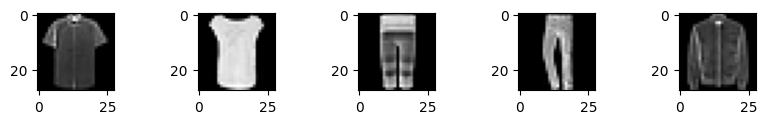

In [34]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 1))
for i in range(5):
    # Set the (i+1)st subplot in a plot with 5 images in 1 row.
    plt.subplot(1, 5, i+1)
    plt.imshow(X_train_full[i], cmap="gray")
print('label for each of the above image: %s' % (y_train_full[0:5]))

In [35]:
X_train_10_class, y_train_10_class = resample(X_train_normalized, y_train_full, {0: 90, 1: 80, 2: 70, 3: 60, 4: 50, 5: 40, 6: 30, 7: 20, 8: 10, 9: 5})
X_test_10_class, y_test_10_class = resample(X_test_normalized, y_test_full, {0: 90, 1: 80, 2: 70, 3: 60, 4: 50, 5: 40, 6: 30, 7: 20, 8: 10, 9: 5})
X_val_10_class, y_val_10_class = resample(X_val_normalized, y_val_full, {0: 90, 1: 80, 2: 70, 3: 60, 4: 50, 5: 40, 6: 30, 7: 20, 8: 10, 9: 5})

num_classes = 10

y_train_10_class_cat = to_categorical(y_train_10_class, num_classes)
y_test_10_class_cat = to_categorical(y_test_10_class, num_classes)
y_val_10_class_cat = to_categorical(y_val_10_class, num_classes)

In [36]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam

# Intializing a sequential model
model_cnn = Sequential()

# Adding first conv layer with 64 filters and kernel size 3x3 , padding 'same' provides the output size same as the input size
# 64 filters produce 64 feature maps
# Input_shape denotes input image dimension of MNIST images
model_cnn.add(Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(28, 28, 1)))
# Adding max pooling to reduce the size of output of first conv layer
model_cnn.add(MaxPooling2D((2, 2), padding = 'same'))

model_cnn.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model_cnn.add(MaxPooling2D((2, 2), padding = 'same'))

model_cnn.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model_cnn.add(MaxPooling2D((2, 2), padding = 'same'))

# flattening the output of the conv layer after max pooling to make it ready for creating dense connections
model_cnn.add(Flatten())

# Adding a fully connected dense layer with 100 neurons
model_cnn.add(Dense(100, activation='relu'))

# Adding the output layer with 1 neuron and activation functions as sigmoid since this is a binary-class classification problem
model_cnn.add(Dense(10, activation='softmax'))

# Need to save the initial weights to train each cnn from scratch
initial_weights = model_cnn.get_weights()

/usr/local/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [37]:
# too computationally intensive to compute every possible boundary for 10 classes so we'll do this randomly
def get_threshold_set(num_classes):
    n = 2000
    rng = np.random.default_rng(6)
    thresholds_set = rng.dirichlet(alpha=np.ones(num_classes), size=n)  # sums to 1
    return thresholds_set

results_10_class = []

for loss_name, loss_fn in loss_fns.items():
    for tune_name, tune_fn in tune_fns.items():
        accuracy, best_threshold, no_tuning_accuracy = multiclass_train_tune_test_pipeline(model_cnn,
                         X_train_10_class, y_train_10_class_cat,
                         X_val_10_class, y_val_10_class_cat,
                         X_test_10_class, y_test_10_class_cat,
                         loss_name, loss_fn, tune_name, tune_fn, split)
        results_10_class.append({
            "split": "90_80_70_60_50_40_30_20_10_5",
            "loss": loss_name,
            "tuned using": tune_name,
            "best threshold": best_threshold,
            "best accuracy": accuracy,
            "accuracy using default softmax": no_tuning_accuracy,
        })

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 14, 14, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 7, 7, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 100)            │        51,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80,662 (315.09 KB)

 Trainable params: 80,662 (315.09 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
171/171 - 10s - 59ms/step - accuracy: 0.7218 - loss: 0.8154 - val_accuracy: 0.8326 - val_loss: 0.4852
Epoch 2/10
171/171 - 10s - 58ms/step - accuracy: 0.8418 - loss: 0.4511 - val_accuracy: 0.8505 - val_loss: 0.4282
Epoch 3/10
171/171 - 7s - 38ms/step - accuracy: 0.8629 - loss: 0.3900 - val_accuracy: 0.8707 - val_loss: 0.3701
Epoch 4/10
171/171 - 6s - 38ms/step - accuracy: 0.8773 - loss: 0.3512 - val_accuracy: 0.8670 - val_loss: 0.3757
Epoch 5/10
171/171 - 6s - 37ms/step - accuracy: 0.8856 - loss: 0.3254 - val_accuracy: 0.8894 - val_loss: 0.3245
Epoch 6/10
171/171 - 6s - 38ms/step - accuracy: 0.8958 - loss: 0.2964 - val_accuracy: 0.8894 - val_loss: 0.3131
Epoch 7/10
171/171 - 7s - 39ms/step - accuracy: 0.8965 - loss: 0.2884 - val_accuracy: 0.8890 - val_loss: 0.3165
Epoch 8/10
171/171 - 7s - 38ms/step - accuracy: 0.9027 - loss: 0.2722 - val_accuracy: 0.8925 - val_loss: 0.3008
Epoch 9/10
171/171 - 6s - 37ms/step - accuracy: 0.9098 - loss: 0.2544 - val_accuracy: 0.8848 - val_los

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 14, 14, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 7, 7, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 100)            │        51,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80,662 (315.09 KB)

 Trainable params: 80,662 (315.09 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
171/171 - 8s - 47ms/step - accuracy: 0.7311 - loss: 0.7908 - val_accuracy: 0.8330 - val_loss: 0.4780
Epoch 2/10
171/171 - 7s - 38ms/step - accuracy: 0.8424 - loss: 0.4519 - val_accuracy: 0.8474 - val_loss: 0.4333
Epoch 3/10
171/171 - 6s - 37ms/step - accuracy: 0.8651 - loss: 0.3865 - val_accuracy: 0.8716 - val_loss: 0.3684
Epoch 4/10
171/171 - 6s - 37ms/step - accuracy: 0.8755 - loss: 0.3530 - val_accuracy: 0.8837 - val_loss: 0.3348
Epoch 5/10
171/171 - 6s - 37ms/step - accuracy: 0.8844 - loss: 0.3253 - val_accuracy: 0.8839 - val_loss: 0.3313
Epoch 6/10
171/171 - 7s - 38ms/step - accuracy: 0.8927 - loss: 0.3013 - val_accuracy: 0.8885 - val_loss: 0.3255
Epoch 7/10
171/171 - 7s - 38ms/step - accuracy: 0.8999 - loss: 0.2845 - val_accuracy: 0.8907 - val_loss: 0.3156
Epoch 8/10
171/171 - 7s - 39ms/step - accuracy: 0.9032 - loss: 0.2712 - val_accuracy: 0.9026 - val_loss: 0.2855
Epoch 9/10
171/171 - 7s - 39ms/step - accuracy: 0.9084 - loss: 0.2619 - val_accuracy: 0.8951 - val_loss:

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 14, 14, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 7, 7, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 100)            │        51,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80,662 (315.09 KB)

 Trainable params: 80,662 (315.09 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
171/171 - 8s - 48ms/step - accuracy: 0.7271 - loss: 0.8015 - val_accuracy: 0.8013 - val_loss: 0.5276
Epoch 2/10
171/171 - 7s - 39ms/step - accuracy: 0.8435 - loss: 0.4478 - val_accuracy: 0.8615 - val_loss: 0.4008
Epoch 3/10
171/171 - 7s - 39ms/step - accuracy: 0.8676 - loss: 0.3777 - val_accuracy: 0.8601 - val_loss: 0.3933
Epoch 4/10
171/171 - 7s - 39ms/step - accuracy: 0.8801 - loss: 0.3488 - val_accuracy: 0.8824 - val_loss: 0.3375
Epoch 5/10
171/171 - 7s - 39ms/step - accuracy: 0.8866 - loss: 0.3236 - val_accuracy: 0.8828 - val_loss: 0.3301
Epoch 6/10
171/171 - 7s - 39ms/step - accuracy: 0.8948 - loss: 0.2957 - val_accuracy: 0.8918 - val_loss: 0.3120
Epoch 7/10
171/171 - 7s - 39ms/step - accuracy: 0.9021 - loss: 0.2807 - val_accuracy: 0.8681 - val_loss: 0.3553
Epoch 8/10
171/171 - 7s - 39ms/step - accuracy: 0.9050 - loss: 0.2708 - val_accuracy: 0.8885 - val_loss: 0.3224
Epoch 9/10
171/171 - 7s - 39ms/step - accuracy: 0.9093 - loss: 0.2552 - val_accuracy: 0.9026 - val_loss:

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 14, 14, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 7, 7, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 100)            │        51,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80,662 (315.09 KB)

 Trainable params: 80,662 (315.09 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
171/171 - 8s - 49ms/step - accuracy: 0.7306 - loss: 0.5718 - val_accuracy: 0.8397 - val_loss: 0.3625
Epoch 2/10
171/171 - 7s - 38ms/step - accuracy: 0.8528 - loss: 0.3414 - val_accuracy: 0.8694 - val_loss: 0.3022
Epoch 3/10
171/171 - 7s - 38ms/step - accuracy: 0.8768 - loss: 0.2956 - val_accuracy: 0.8784 - val_loss: 0.2845
Epoch 4/10
171/171 - 7s - 38ms/step - accuracy: 0.8842 - loss: 0.2766 - val_accuracy: 0.8855 - val_loss: 0.2762
Epoch 5/10
171/171 - 7s - 38ms/step - accuracy: 0.8959 - loss: 0.2516 - val_accuracy: 0.8850 - val_loss: 0.2766
Epoch 6/10
171/171 - 7s - 39ms/step - accuracy: 0.9011 - loss: 0.2355 - val_accuracy: 0.8921 - val_loss: 0.2496
Epoch 7/10
171/171 - 7s - 38ms/step - accuracy: 0.9077 - loss: 0.2228 - val_accuracy: 0.8958 - val_loss: 0.2393
Epoch 8/10
171/171 - 7s - 39ms/step - accuracy: 0.9127 - loss: 0.2110 - val_accuracy: 0.8991 - val_loss: 0.2413
Epoch 9/10
171/171 - 7s - 39ms/step - accuracy: 0.9161 - loss: 0.2052 - val_accuracy: 0.8985 - val_loss:

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 14, 14, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 7, 7, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 100)            │        51,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80,662 (315.09 KB)

 Trainable params: 80,662 (315.09 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
171/171 - 8s - 50ms/step - accuracy: 0.7201 - loss: 0.5857 - val_accuracy: 0.8434 - val_loss: 0.3627
Epoch 2/10
171/171 - 7s - 39ms/step - accuracy: 0.8481 - loss: 0.3500 - val_accuracy: 0.8564 - val_loss: 0.3306
Epoch 3/10
171/171 - 7s - 39ms/step - accuracy: 0.8736 - loss: 0.3031 - val_accuracy: 0.8751 - val_loss: 0.2953
Epoch 4/10
171/171 - 7s - 39ms/step - accuracy: 0.8848 - loss: 0.2721 - val_accuracy: 0.8795 - val_loss: 0.2748
Epoch 5/10
171/171 - 7s - 38ms/step - accuracy: 0.8962 - loss: 0.2510 - val_accuracy: 0.8874 - val_loss: 0.2653
Epoch 6/10
171/171 - 10s - 60ms/step - accuracy: 0.9016 - loss: 0.2380 - val_accuracy: 0.8912 - val_loss: 0.2577
Epoch 7/10
171/171 - 7s - 39ms/step - accuracy: 0.9045 - loss: 0.2287 - val_accuracy: 0.8929 - val_loss: 0.2515
Epoch 8/10
171/171 - 7s - 39ms/step - accuracy: 0.9098 - loss: 0.2154 - val_accuracy: 0.9004 - val_loss: 0.2377
Epoch 9/10
171/171 - 7s - 38ms/step - accuracy: 0.9154 - loss: 0.2037 - val_accuracy: 0.8998 - val_loss

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 14, 14, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 7, 7, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 100)            │        51,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80,662 (315.09 KB)

 Trainable params: 80,662 (315.09 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
171/171 - 8s - 48ms/step - accuracy: 0.7260 - loss: 0.5801 - val_accuracy: 0.8304 - val_loss: 0.3957
Epoch 2/10
171/171 - 10s - 58ms/step - accuracy: 0.8493 - loss: 0.3499 - val_accuracy: 0.8678 - val_loss: 0.3208
Epoch 3/10
171/171 - 10s - 60ms/step - accuracy: 0.8758 - loss: 0.2964 - val_accuracy: 0.8782 - val_loss: 0.2919
Epoch 4/10
171/171 - 7s - 38ms/step - accuracy: 0.8876 - loss: 0.2674 - val_accuracy: 0.8811 - val_loss: 0.2801
Epoch 5/10
171/171 - 7s - 38ms/step - accuracy: 0.8939 - loss: 0.2539 - val_accuracy: 0.8874 - val_loss: 0.2612
Epoch 6/10
171/171 - 6s - 38ms/step - accuracy: 0.9018 - loss: 0.2331 - val_accuracy: 0.8960 - val_loss: 0.2424
Epoch 7/10
171/171 - 7s - 39ms/step - accuracy: 0.9056 - loss: 0.2260 - val_accuracy: 0.8929 - val_loss: 0.2420
Epoch 8/10
171/171 - 6s - 38ms/step - accuracy: 0.9113 - loss: 0.2159 - val_accuracy: 0.8976 - val_loss: 0.2450
Epoch 9/10
171/171 - 6s - 38ms/step - accuracy: 0.9155 - loss: 0.2011 - val_accuracy: 0.9031 - val_los

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 14, 14, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 7, 7, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 100)            │        51,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80,662 (315.09 KB)

 Trainable params: 80,662 (315.09 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
171/171 - 8s - 49ms/step - accuracy: 0.5996 - loss: 0.4745 - val_accuracy: 0.6518 - val_loss: 0.3977
Epoch 2/10
171/171 - 7s - 38ms/step - accuracy: 0.6816 - loss: 0.3772 - val_accuracy: 0.7007 - val_loss: 0.3677
Epoch 3/10
171/171 - 7s - 39ms/step - accuracy: 0.7009 - loss: 0.3626 - val_accuracy: 0.7084 - val_loss: 0.3495
Epoch 4/10
171/171 - 7s - 39ms/step - accuracy: 0.7095 - loss: 0.3352 - val_accuracy: 0.7115 - val_loss: 0.3322
Epoch 5/10
171/171 - 6s - 38ms/step - accuracy: 0.7186 - loss: 0.3249 - val_accuracy: 0.7183 - val_loss: 0.3153
Epoch 6/10
171/171 - 6s - 38ms/step - accuracy: 0.7277 - loss: 0.3114 - val_accuracy: 0.7165 - val_loss: 0.3207
Epoch 7/10
171/171 - 7s - 38ms/step - accuracy: 0.7377 - loss: 0.3052 - val_accuracy: 0.7385 - val_loss: 0.3039
Epoch 8/10
171/171 - 10s - 59ms/step - accuracy: 0.7373 - loss: 0.3029 - val_accuracy: 0.7390 - val_loss: 0.3003
Epoch 9/10
171/171 - 6s - 38ms/step - accuracy: 0.7417 - loss: 0.3005 - val_accuracy: 0.7518 - val_loss

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 14, 14, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 7, 7, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 100)            │        51,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80,662 (315.09 KB)

 Trainable params: 80,662 (315.09 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
171/171 - 8s - 46ms/step - accuracy: 0.6364 - loss: 0.4183 - val_accuracy: 0.7148 - val_loss: 0.3787
Epoch 2/10
171/171 - 6s - 36ms/step - accuracy: 0.7611 - loss: 0.3149 - val_accuracy: 0.7907 - val_loss: 0.2581
Epoch 3/10
171/171 - 6s - 38ms/step - accuracy: 0.8010 - loss: 0.2472 - val_accuracy: 0.8115 - val_loss: 0.2485
Epoch 4/10
171/171 - 6s - 38ms/step - accuracy: 0.8116 - loss: 0.2401 - val_accuracy: 0.8179 - val_loss: 0.2350
Epoch 5/10
171/171 - 11s - 62ms/step - accuracy: 0.8175 - loss: 0.2320 - val_accuracy: 0.8289 - val_loss: 0.2212
Epoch 6/10
171/171 - 7s - 39ms/step - accuracy: 0.8297 - loss: 0.2245 - val_accuracy: 0.8425 - val_loss: 0.2109
Epoch 7/10
171/171 - 7s - 39ms/step - accuracy: 0.8385 - loss: 0.2117 - val_accuracy: 0.8401 - val_loss: 0.2012
Epoch 8/10
171/171 - 7s - 38ms/step - accuracy: 0.8406 - loss: 0.2002 - val_accuracy: 0.8277 - val_loss: 0.2142
Epoch 9/10
171/171 - 10s - 60ms/step - accuracy: 0.8374 - loss: 0.2135 - val_accuracy: 0.8315 - val_los

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 14, 14, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 7, 7, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 100)            │        51,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80,662 (315.09 KB)

 Trainable params: 80,662 (315.09 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
171/171 - 8s - 49ms/step - accuracy: 0.5920 - loss: 0.4710 - val_accuracy: 0.6804 - val_loss: 0.3781
Epoch 2/10
171/171 - 7s - 38ms/step - accuracy: 0.6829 - loss: 0.3784 - val_accuracy: 0.7024 - val_loss: 0.3750
Epoch 3/10
171/171 - 7s - 38ms/step - accuracy: 0.6960 - loss: 0.3679 - val_accuracy: 0.7070 - val_loss: 0.3561
Epoch 4/10
171/171 - 7s - 38ms/step - accuracy: 0.7013 - loss: 0.3638 - val_accuracy: 0.7071 - val_loss: 0.3539
Epoch 5/10
171/171 - 7s - 39ms/step - accuracy: 0.7087 - loss: 0.3399 - val_accuracy: 0.7249 - val_loss: 0.3313
Epoch 6/10
171/171 - 7s - 39ms/step - accuracy: 0.7288 - loss: 0.3213 - val_accuracy: 0.7299 - val_loss: 0.3124
Epoch 7/10
171/171 - 7s - 39ms/step - accuracy: 0.7277 - loss: 0.3170 - val_accuracy: 0.7368 - val_loss: 0.3116
Epoch 8/10
171/171 - 7s - 39ms/step - accuracy: 0.7359 - loss: 0.3095 - val_accuracy: 0.7447 - val_loss: 0.3065
Epoch 9/10
171/171 - 7s - 39ms/step - accuracy: 0.7366 - loss: 0.3052 - val_accuracy: 0.7375 - val_loss:

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 14, 14, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 7, 7, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 100)            │        51,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80,662 (315.09 KB)

 Trainable params: 80,662 (315.09 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
171/171 - 9s - 50ms/step - accuracy: 0.6831 - loss: 0.5318 - val_accuracy: 0.7625 - val_loss: 0.4407
Epoch 2/10
171/171 - 7s - 39ms/step - accuracy: 0.7756 - loss: 0.3895 - val_accuracy: 0.8059 - val_loss: 0.3351
Epoch 3/10
171/171 - 7s - 40ms/step - accuracy: 0.7967 - loss: 0.3244 - val_accuracy: 0.8240 - val_loss: 0.2813
Epoch 4/10
171/171 - 7s - 39ms/step - accuracy: 0.8216 - loss: 0.2909 - val_accuracy: 0.8333 - val_loss: 0.2850
Epoch 5/10
171/171 - 7s - 39ms/step - accuracy: 0.8295 - loss: 0.2843 - val_accuracy: 0.8211 - val_loss: 0.3090
Epoch 6/10
171/171 - 7s - 39ms/step - accuracy: 0.8418 - loss: 0.2735 - val_accuracy: 0.8473 - val_loss: 0.2626
Epoch 7/10
171/171 - 7s - 39ms/step - accuracy: 0.8500 - loss: 0.2592 - val_accuracy: 0.8432 - val_loss: 0.2675
Epoch 8/10
171/171 - 7s - 39ms/step - accuracy: 0.8527 - loss: 0.2591 - val_accuracy: 0.8593 - val_loss: 0.2548
Epoch 9/10
171/171 - 7s - 39ms/step - accuracy: 0.8582 - loss: 0.2514 - val_accuracy: 0.8548 - val_loss:

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 14, 14, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 7, 7, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 100)            │        51,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80,662 (315.09 KB)

 Trainable params: 80,662 (315.09 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
171/171 - 8s - 50ms/step - accuracy: 0.6469 - loss: 0.5561 - val_accuracy: 0.6998 - val_loss: 0.4972
Epoch 2/10
171/171 - 7s - 38ms/step - accuracy: 0.7185 - loss: 0.4665 - val_accuracy: 0.7663 - val_loss: 0.3988
Epoch 3/10
171/171 - 7s - 40ms/step - accuracy: 0.7840 - loss: 0.3708 - val_accuracy: 0.7808 - val_loss: 0.3255
Epoch 4/10
171/171 - 7s - 39ms/step - accuracy: 0.8136 - loss: 0.2996 - val_accuracy: 0.8262 - val_loss: 0.2813
Epoch 5/10
171/171 - 7s - 39ms/step - accuracy: 0.8321 - loss: 0.2795 - val_accuracy: 0.8328 - val_loss: 0.2760
Epoch 6/10
171/171 - 7s - 40ms/step - accuracy: 0.8407 - loss: 0.2709 - val_accuracy: 0.8507 - val_loss: 0.2635
Epoch 7/10
171/171 - 7s - 40ms/step - accuracy: 0.8440 - loss: 0.2725 - val_accuracy: 0.8495 - val_loss: 0.2576
Epoch 8/10
171/171 - 7s - 40ms/step - accuracy: 0.8482 - loss: 0.2629 - val_accuracy: 0.8584 - val_loss: 0.2560
Epoch 9/10
171/171 - 7s - 40ms/step - accuracy: 0.8546 - loss: 0.2543 - val_accuracy: 0.8500 - val_loss:

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 14, 14, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 7, 7, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 100)            │        51,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80,662 (315.09 KB)

 Trainable params: 80,662 (315.09 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
171/171 - 9s - 51ms/step - accuracy: 0.6883 - loss: 0.5265 - val_accuracy: 0.7288 - val_loss: 0.4769
Epoch 2/10
171/171 - 9s - 55ms/step - accuracy: 0.7518 - loss: 0.4325 - val_accuracy: 0.7553 - val_loss: 0.4115
Epoch 3/10
171/171 - 7s - 38ms/step - accuracy: 0.7931 - loss: 0.3842 - val_accuracy: 0.8057 - val_loss: 0.3703
Epoch 4/10
171/171 - 7s - 38ms/step - accuracy: 0.8052 - loss: 0.3711 - val_accuracy: 0.8042 - val_loss: 0.3795
Epoch 5/10
171/171 - 10s - 60ms/step - accuracy: 0.8328 - loss: 0.2912 - val_accuracy: 0.8273 - val_loss: 0.2916
Epoch 6/10
171/171 - 7s - 39ms/step - accuracy: 0.8430 - loss: 0.2706 - val_accuracy: 0.8405 - val_loss: 0.2663
Epoch 7/10
171/171 - 10s - 60ms/step - accuracy: 0.8485 - loss: 0.2632 - val_accuracy: 0.8419 - val_loss: 0.2603
Epoch 8/10
171/171 - 7s - 39ms/step - accuracy: 0.8517 - loss: 0.2549 - val_accuracy: 0.8410 - val_loss: 0.2593
Epoch 9/10
171/171 - 7s - 39ms/step - accuracy: 0.8535 - loss: 0.2561 - val_accuracy: 0.8516 - val_los

In [38]:
results_10_class

[{'split': '90_80_70_60_50_40_30_20_10_5',
  'loss': 'categorical crossentropy',
  'tuned using': 'decision tree',
  'best threshold': DecisionTreeClassifier(max_depth=1, random_state=6),
  'best accuracy': 0.3687912087912088,
  'accuracy using default softmax': 0.8841758241758242},
 {'split': '90_80_70_60_50_40_30_20_10_5',
  'loss': 'categorical crossentropy',
  'tuned using': 'threshold absolute difference',
  'best threshold': array([0.21174151, 0.01640823, 0.0244177 , 0.14675482, 0.38846221,
         0.06107742, 0.04671588, 0.04555175, 0.02364383, 0.03522666]),
  'best accuracy': 0.8876923076923077,
  'accuracy using default softmax': 0.8861538461538462},
 {'split': '90_80_70_60_50_40_30_20_10_5',
  'loss': 'categorical crossentropy',
  'tuned using': 'threshold relative difference',
  'best threshold': array([0.10674764, 0.10331981, 0.05716603, 0.14317121, 0.13959464,
         0.12717564, 0.04979836, 0.11769789, 0.07318329, 0.08214549]),
  'best accuracy': 0.8901098901098901,
  '